(plots_intro)=
# Introduction to batteries-included plots

In this tutorial, we'll show how to interact with the {term}`aesthetics` mapping and {term}`faceting` powered by {class}`~arviz_plots.PlotCollection`. To keep the example concrete, we'll use {func}`~arviz_plots.plot_dist`, but the main concepts apply to other `plot_...` plotting functions in `arviz_plots`. The tutorial assumes basic familiarity with ArviZ and the InferenceData schema. We recommend starting with the {ref}`overview_plots` page if that were not the case.


{func}`~arviz_plots.plot_dist` is a "batteries-included" function that plots 1D marginal distributions in the style of John K. Kruschke's __[_Doing Bayesian Data Analysis_](https://sites.google.com/site/doingbayesiandataanalysis/)__ book. In older versions of ArviZ it used to be called `plot_posterior`.

In [1]:
import arviz_plots as azp
from arviz_base import load_arviz_data

In [2]:
azp.style.use("arviz-variat")

In [3]:
schools = load_arviz_data("centered_eight")

## Default behaviour

`plot_...` functions only have one required argument, the data to be plotted as `DataTree`.
These functions have a set of defaults regarding {term}`faceting`, layout of {term}`visual elements <visuals>` and labeling which should hopefully generate sensible figures independently of the data.

In `plot_dist`'s case, the default is to generate a {term}`figure` with multiple {term}`plots`, with as many plots as variables and individual coordinate value combinations (after reducing the sampled dimensions). The `schools` dataset has 3 variables: `mu` and `tau` are scalar parameters of the model, and `theta` has an extra dimension `school` with 8 coordinate values.
Thus, a grid with $1+1+8=10$ plots is generated:

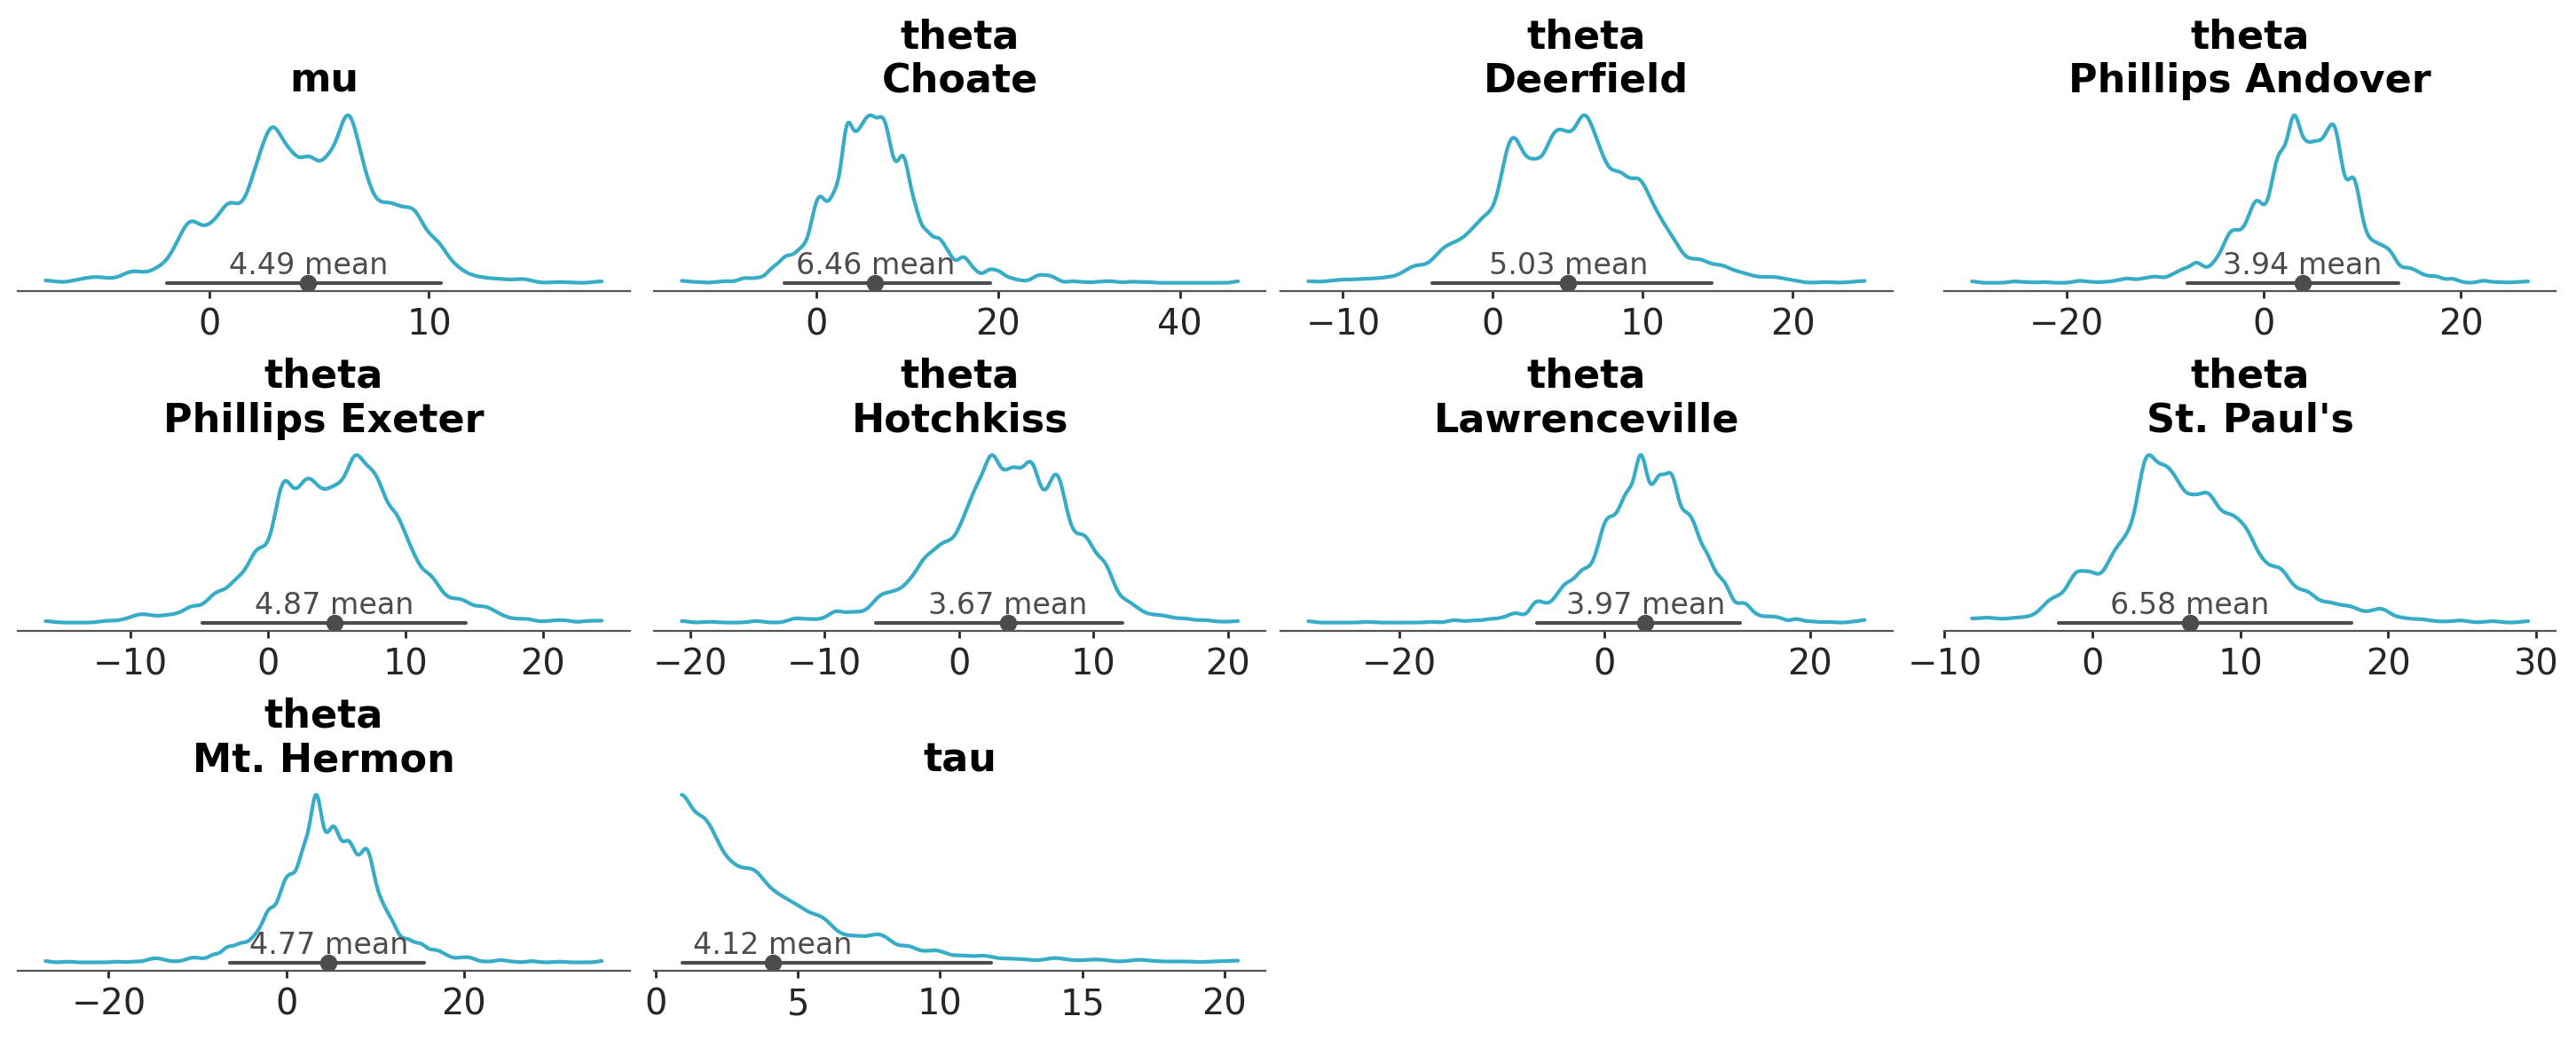

In [4]:
azp.plot_dist(schools);

As you can see, each plot contains 3 statistical quantities derived from the data: 

* A visual representation of the marginal probability distribution, here represented with a Kernel Density Estimate (KDE)
* A credible interval, by default an equal tail interval, here represented with a line 
* A point estimate, by default the mean, here represented with a filled circle.

Each `plot_...` will present different quantities using different representations, but the pattern remains the same.

## Customizing the plot

There are a handful of top level keyword arguments, related to data selection and general properties of the plot, and then a handful of arguments that take dictionaries and can provide finer control on the function behaviour.

In `plot_dist`'s case, the top level arguments are:

* Data selection related: `var_names`, `filter_vars`, `coords`, `group` and `sample_dims`. These arguments are used to select the data to be plotted and usually are available in all `plot_...` functions.
* Specific properties: `kind` to choose how to represent the marginal distributions, `point_estimate` to choose which point estimate to use, and `ci_kind` and `ci_prob` to control the credible interval. These arguments are specific to `plot_dist` but similar arguments are available in other `plot_...` functions. For example, the other plots that show marginal distributions will also have a `kind` argument to choose the visual representation of the distribution.
* General properties: `plot_collection` in case you want to provide an existing {class}`~arviz_plots.PlotCollection` class, `backend` to choose the plotting backend, and `labeller` to chose how to label each plot. These arguments are available in all `plot_...` functions.
* Dictionary arguments: `visuals`, `stats`, `pc_kwargs` and `aes_by_visuals`. These arguments are used to customize the behaviour of the plot in a more fine-grained way.


The arguments requiring more explanation are, most likely, the dictionary arguments. In addition to being the newest ones, they also differ from common usage patterns within the scientific python ecosystem.
In the following sections we'll show how to use these arguments in detail.

## `visuals`

`visuals` is a dictionary that dispatches keyword arguments through to the backend plotting functions. Its keys should be graphical elements, and its values should be dictionaries that are passed as is to the plotting functions. It is also possible to use `False` as values to remove that visual element form the plot. The docstrings of each `plot_...` function indicate which are the valid top level keys and where each dictionary value is dispatched to. 

The docstring of {func}`~arviz_plots.plot_dist` indicates all valid keys `visuals` can take:

> **visuals : mapping of {str : mapping or False}, optional**
>
>   Valid keys are:
>
>   * One of "kde", "ecdf", "dot" or "hist", matching the `kind` argument.
>   * credible_interval -> passed to :func:`~arviz_plots.visuals.line_x`
>   * point_estimate -> passed to :func:`~arviz_plots.visuals.scatter_x`
>   * point_estimate_text -> passed to :func:`~arviz_plots.visuals.point_estimate_text`
>   * title -> passed to :func:`~arviz_plots.visuals.labelled_title`
>   * rug -> passed to :func:`~arviz_plots.visuals.scatter_x`. Defaults to False.
>   * remove_axis -> not passed anywhere, can only be ``False`` to skip calling this function

:::{tip}
If you use an editor with support for type hints, the type hint information of the argument also includes which are the valid keys.
:::

### Modify properties of visual elements in all plots
We can use it to change the color of the KDE line:

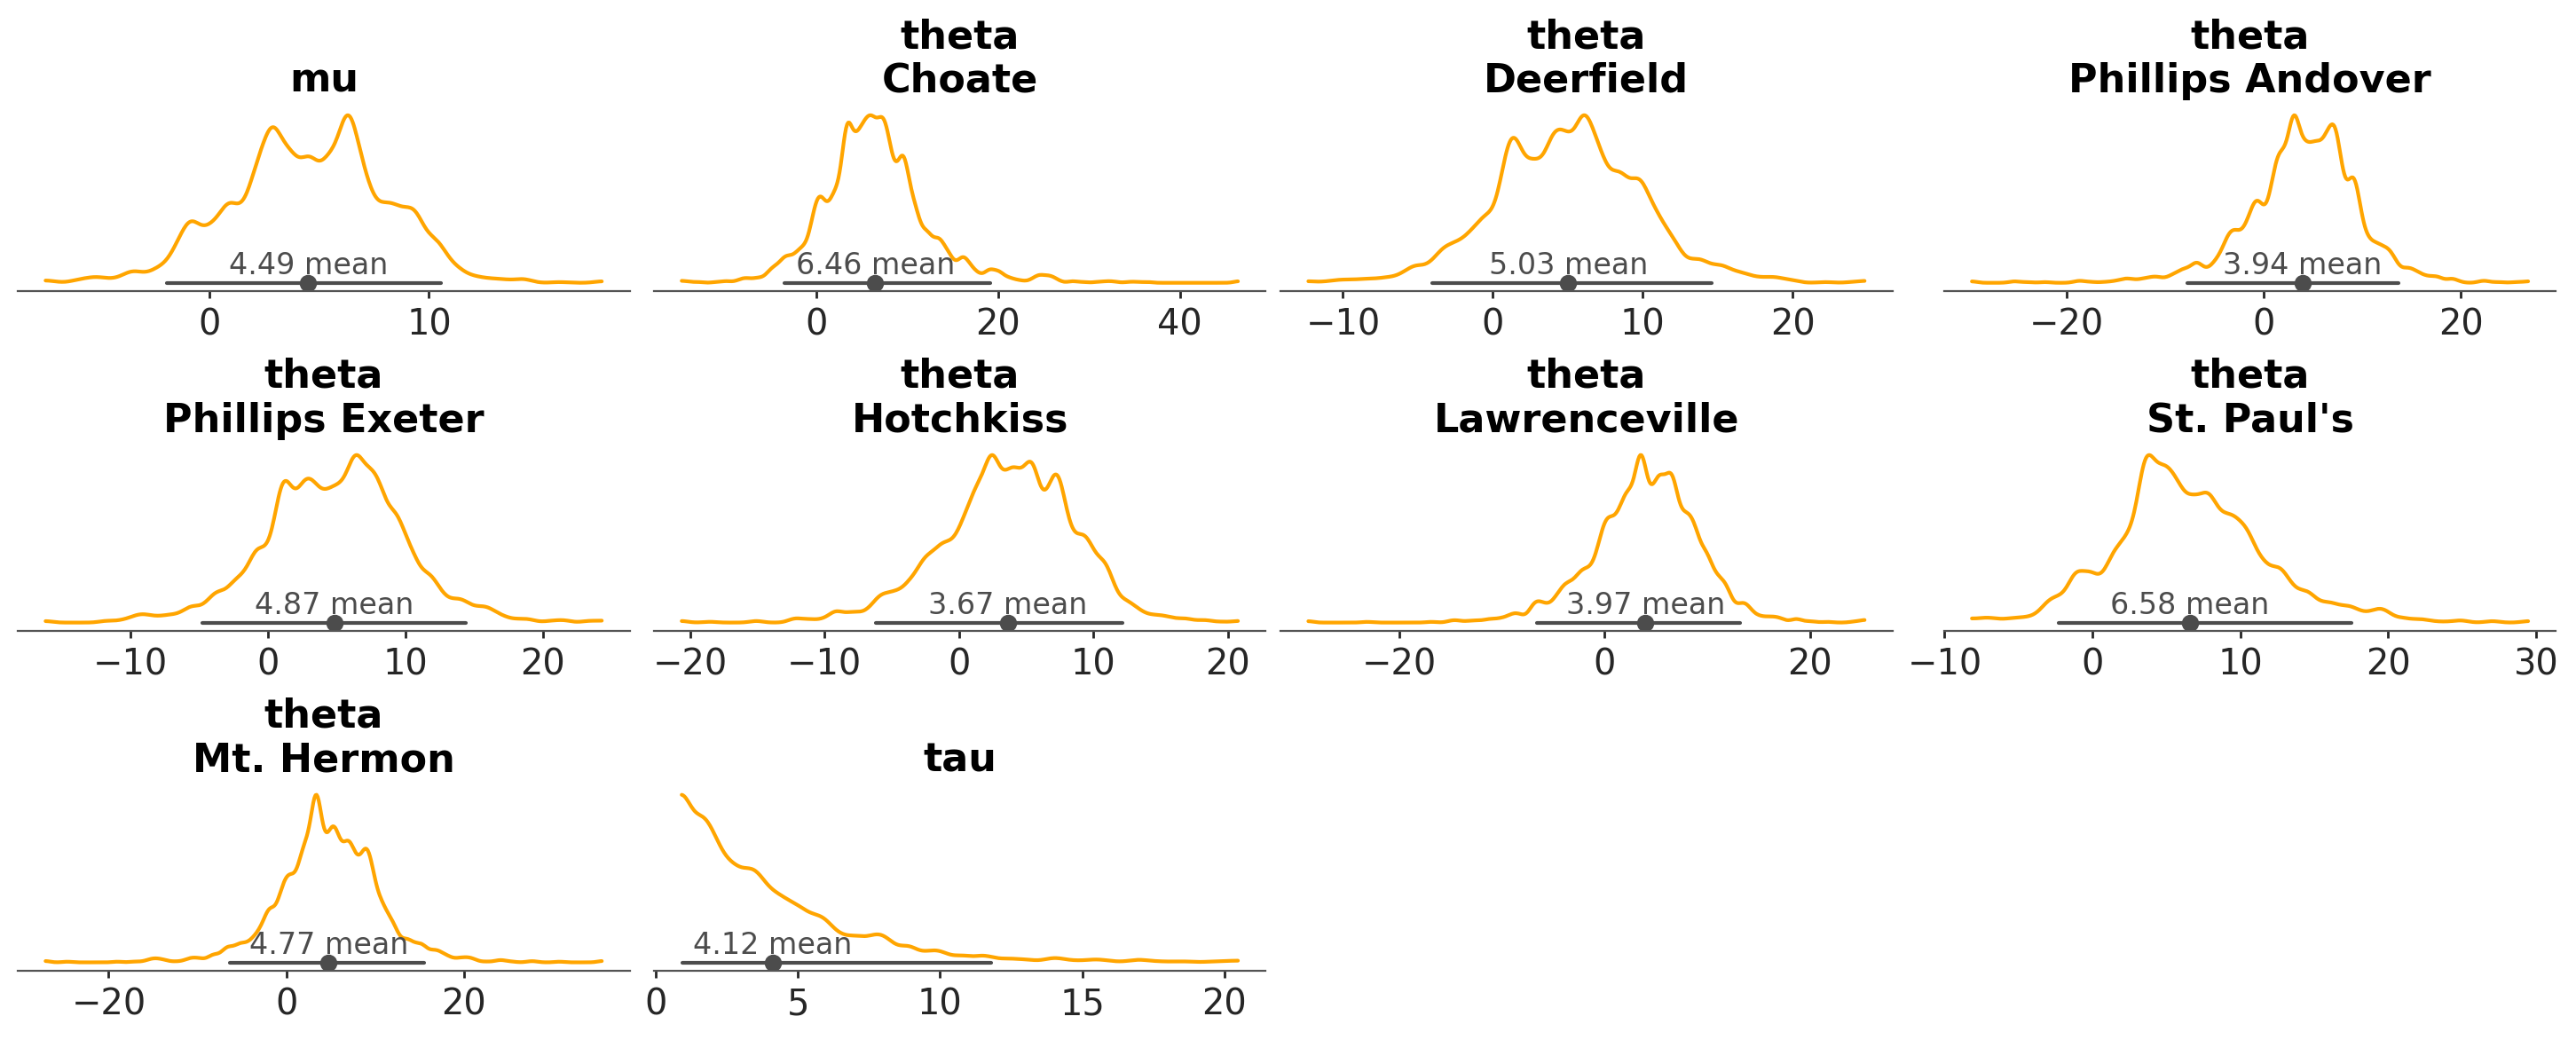

In [5]:
azp.plot_dist(schools, visuals={"kde": {"color": "orange"}});

Or to change the color and linestyle of the credible interval together with the fonts of the point estimate annotation and title:

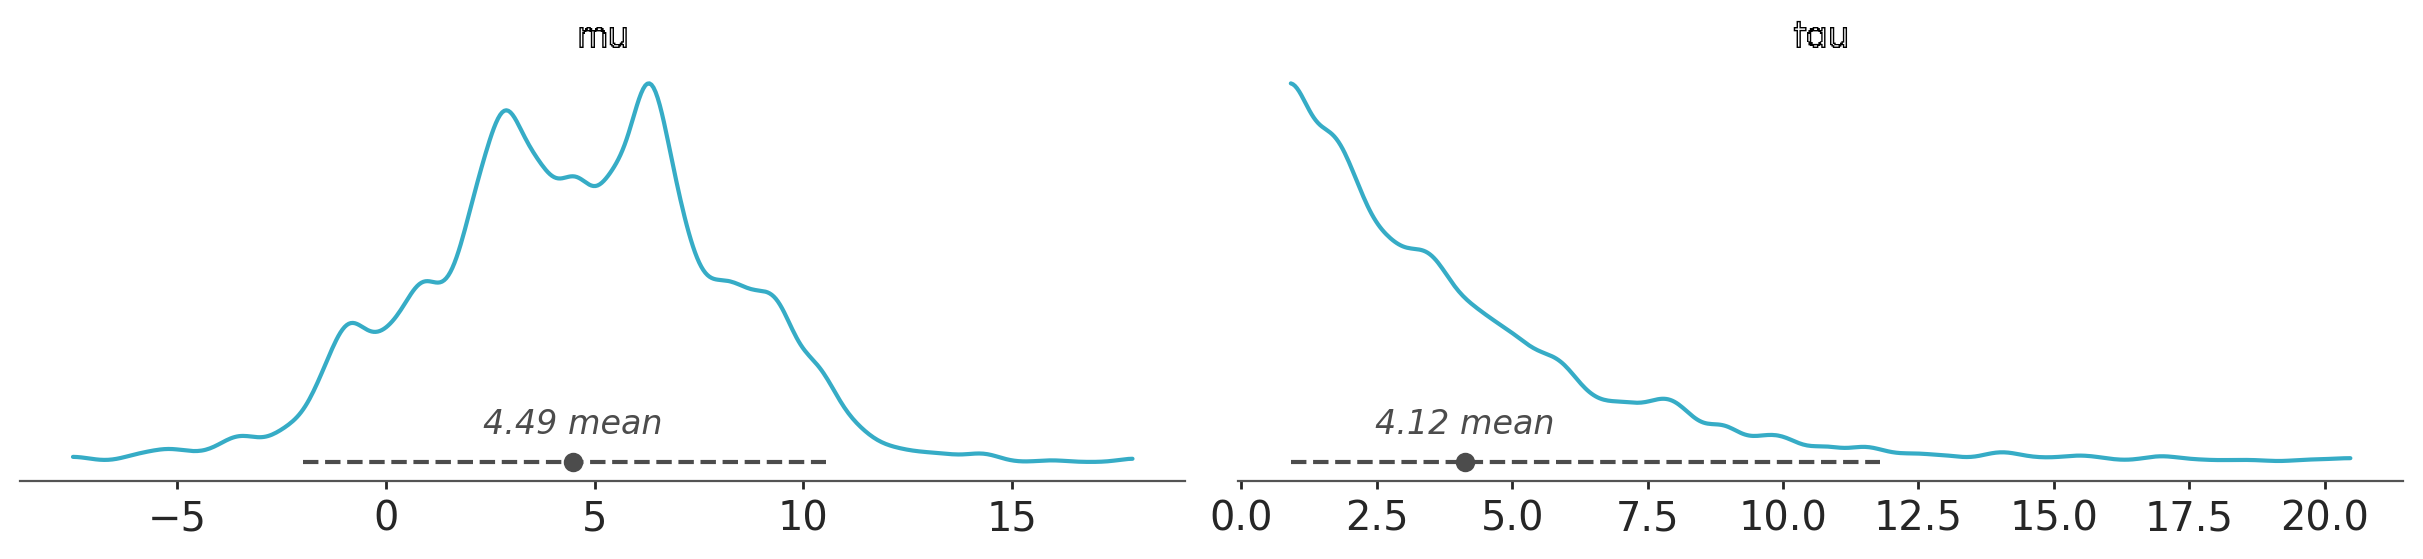

In [6]:
azp.plot_dist(
    schools,
    var_names=["mu", "tau"],
    visuals={
        "credible_interval": {"linestyle": "--"},
        "point_estimate_text": {"fontstyle": "italic"},
        #  font available at: https://gitlab.com/raphaelbastide/Terminal-Grotesque
        "title": {"fontfamily": "Terminal Grotesque Open"}
    }
);

### Remove visual elements from the plot
`visuals` can also be used to remove visual elements from the plot. For example, to keep only the marginal distribution representation:

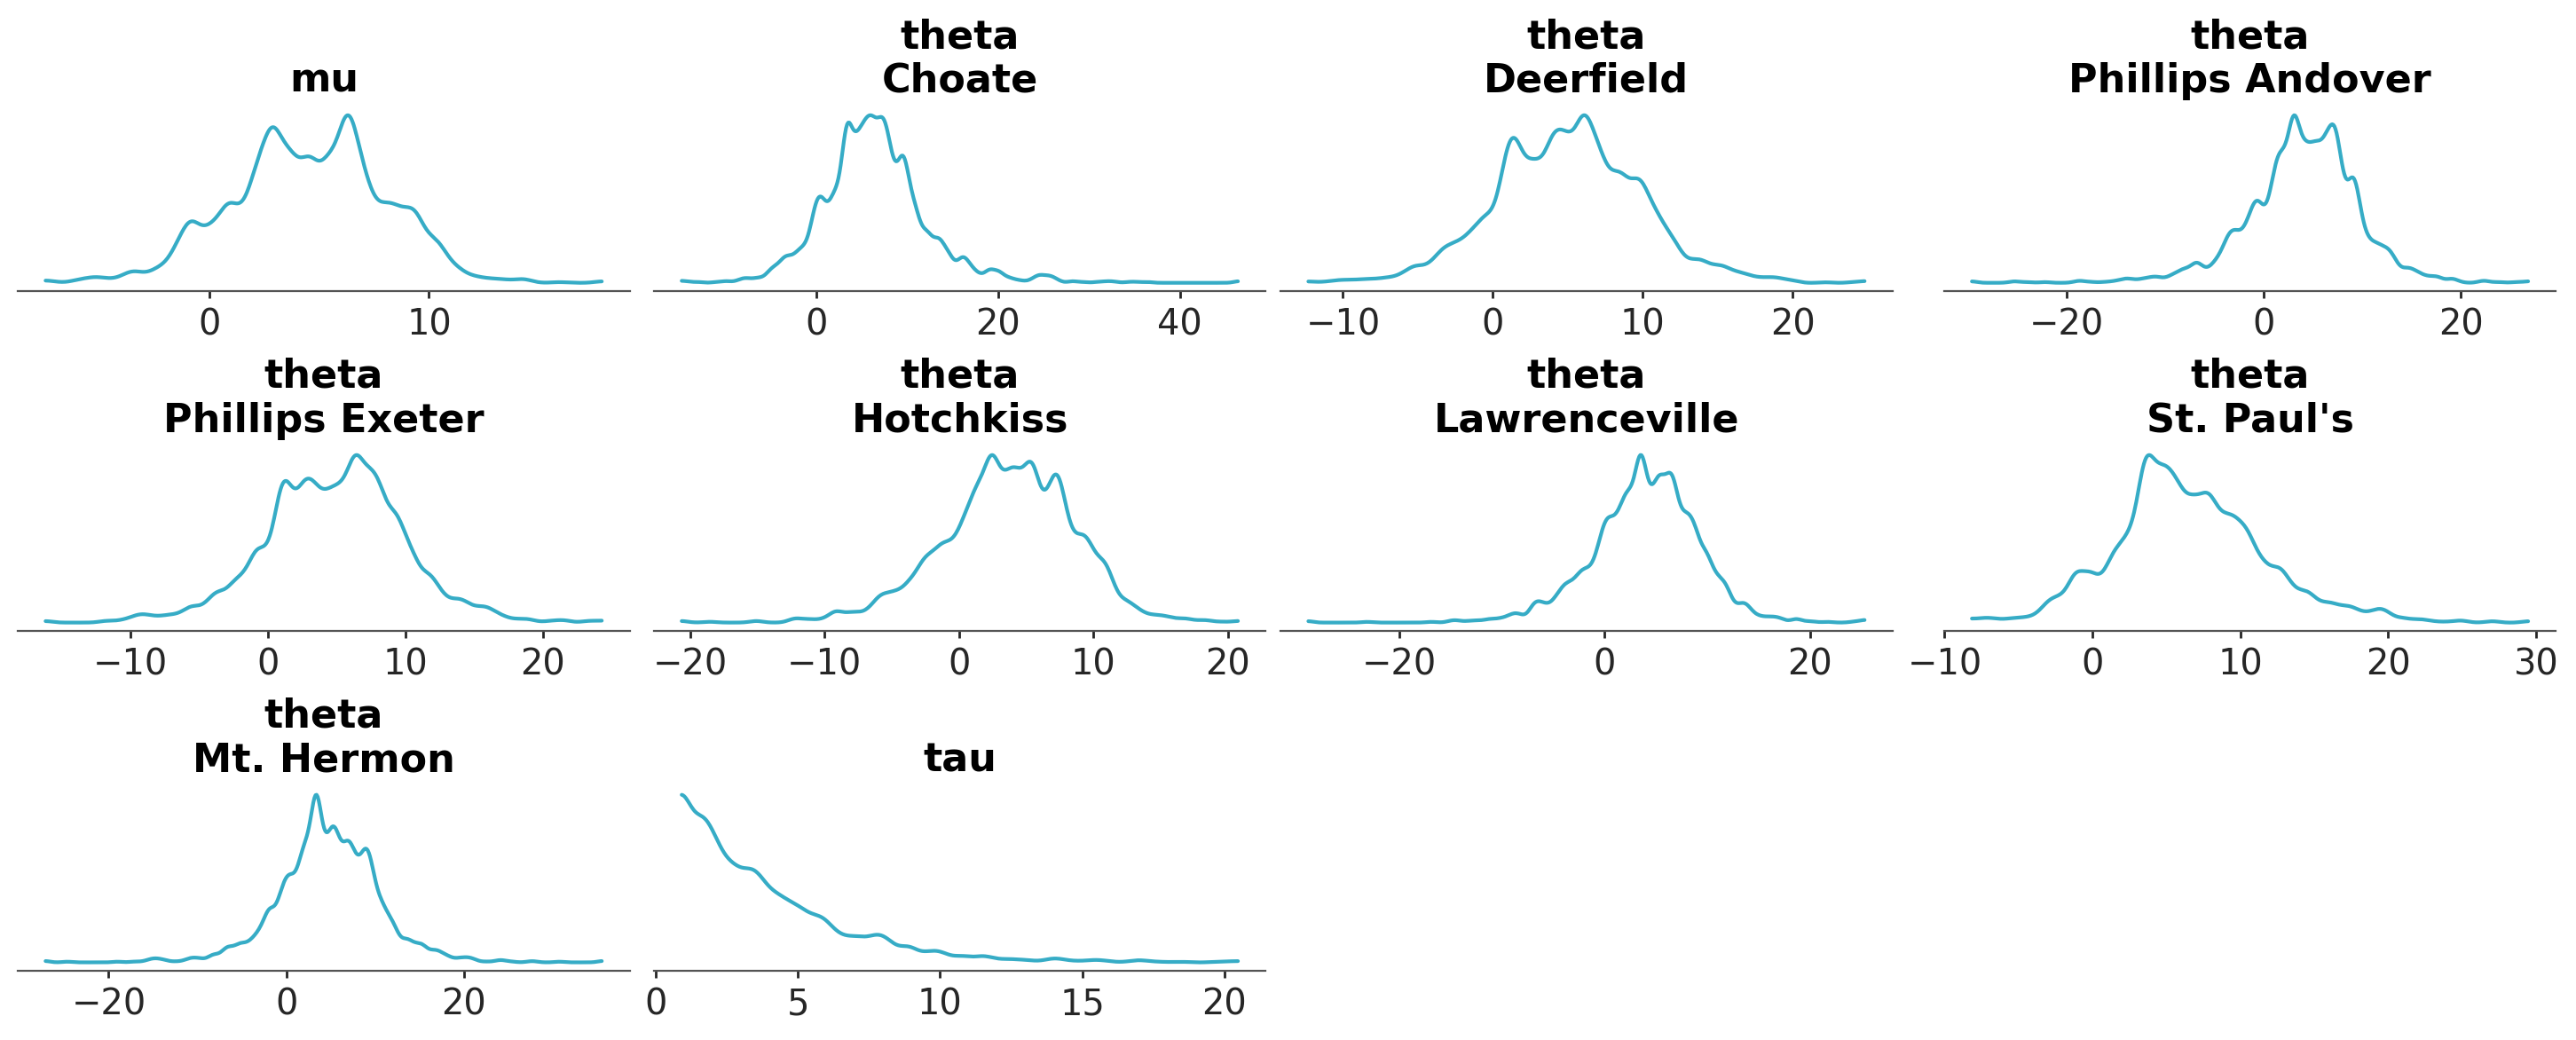

In [7]:
azp.plot_dist(
    schools, 
    visuals={
        "credible_interval": False,
        "point_estimate": False,
        "point_estimate_text": False,
    }
);

## `stats`
`stats` is a dictionary that dispatches keyword arguments through to the statistical computation function. In this case, its keys are statistical computations, and its values are dictionaries that are passed as is to functions in `arviz-stats`. It is also possible to use {class}`xarray.Dataset` as values to provide pre-computed values of that statistic.

For example, we can use it in `plot_dist` to control the KDE computation and modify the bandwidth selection algorithm:

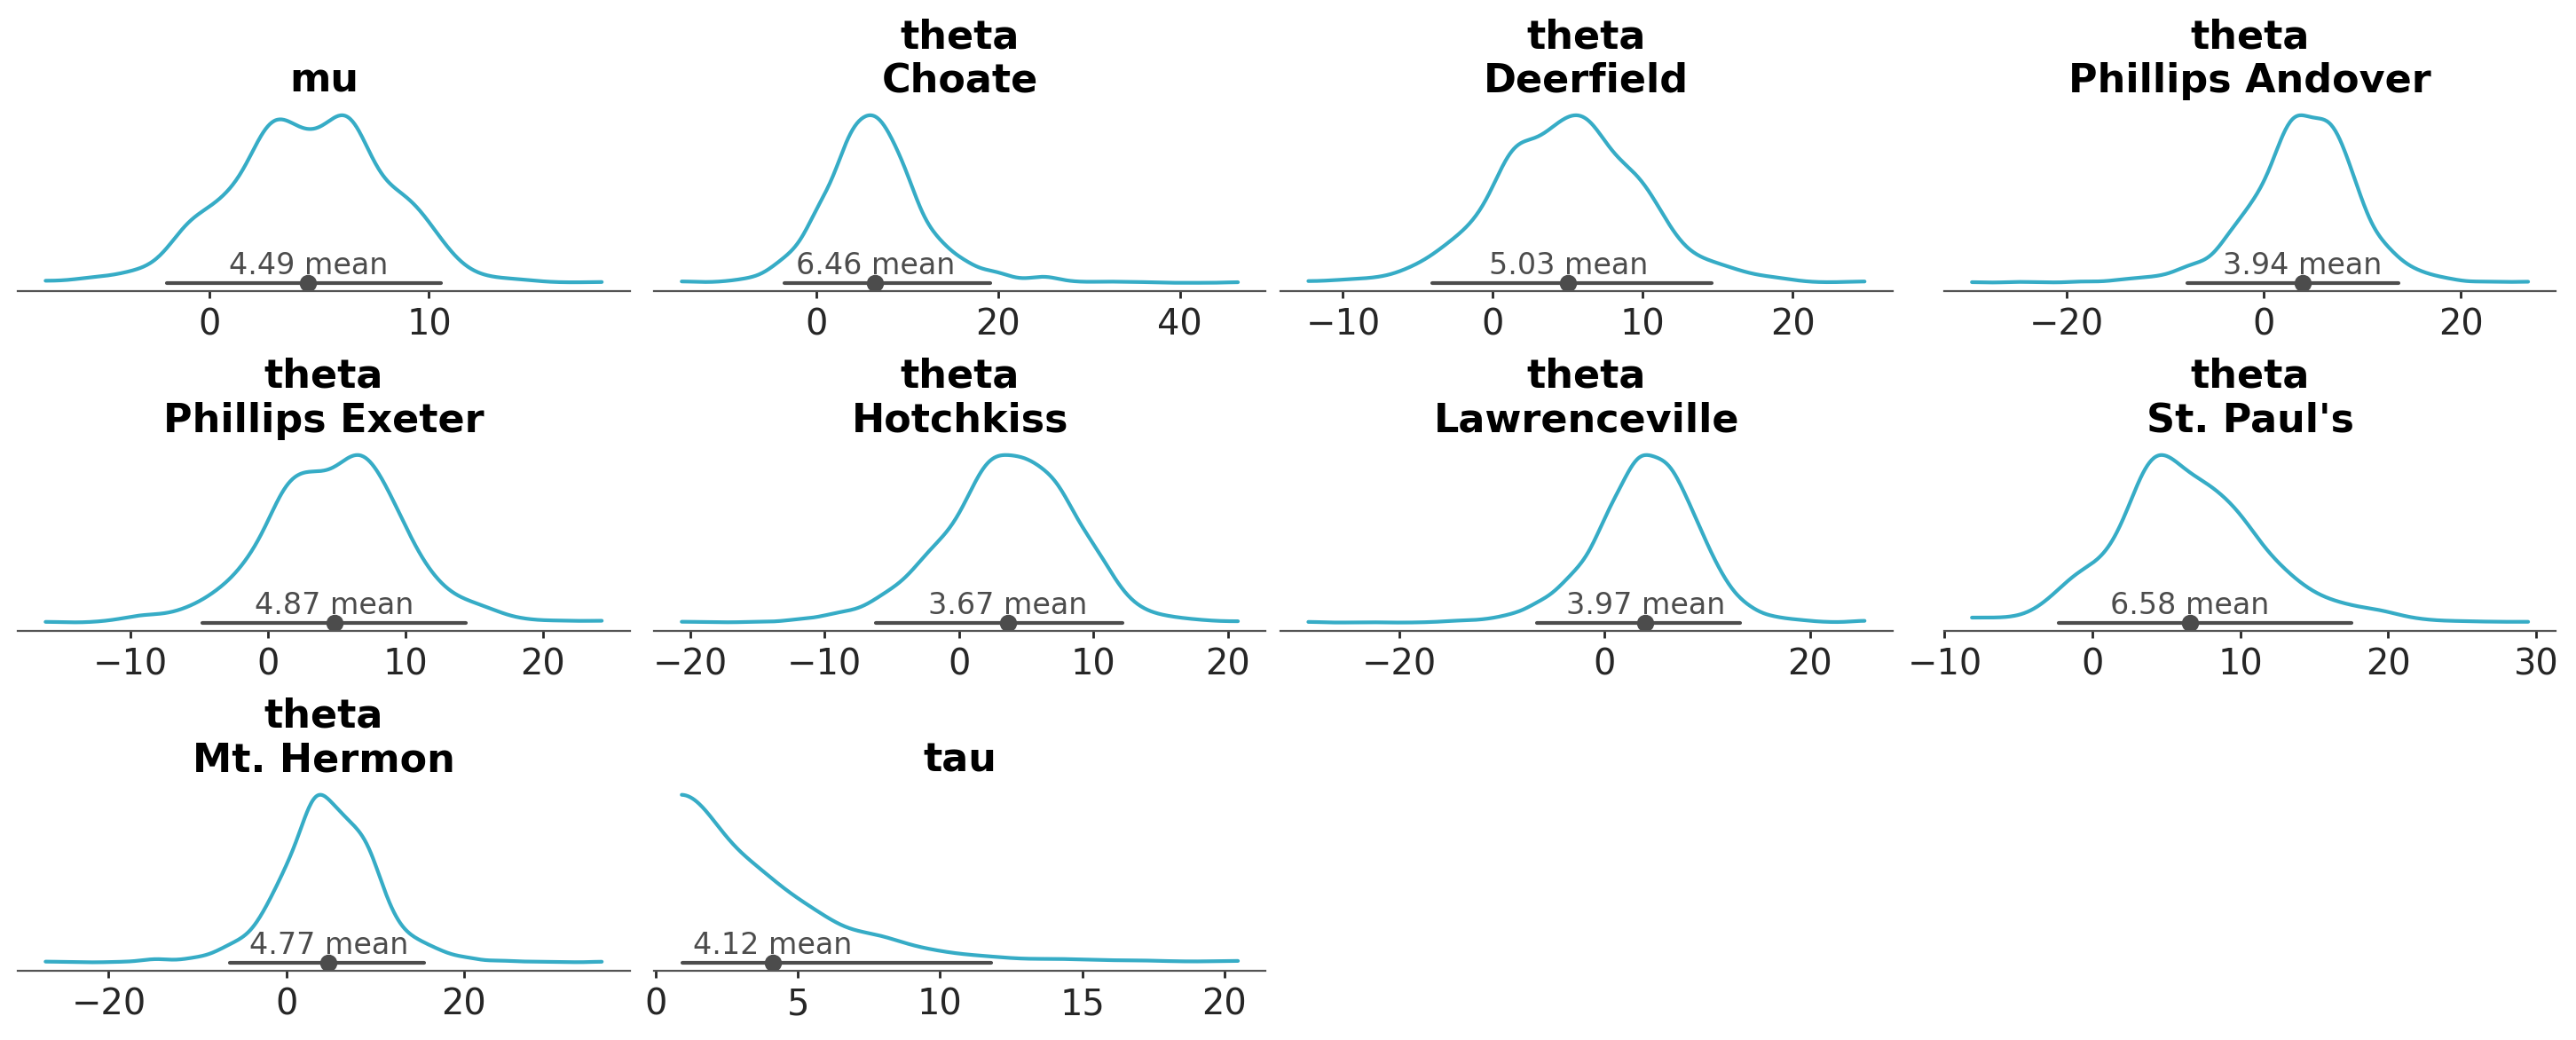

In [8]:
azp.plot_dist(schools, stats={"density": {"bw": "scott"}});

## `**pc_kwargs` and `aes_by_visuals`
`**pc_kwargs` are passed to {meth}`arviz_plots.PlotCollection.wrap` to initialize the `PlotCollection` object that takes care of facetting and aesthetics mapping, and to generate and manage the figure. With it we can regulate from the figure size or sharing of axis limits, to modifying completely the layout and aesthetics of the generated plot. Most functions use `.wrap` to initialize the `PlotCollection` class, but some use {meth}`arviz_plots.PlotCollection.grid`. The docstring of each function will indicate which is being used.

Each figure has a set of mappings between dataset properties and graphical properties. For example, we might encode the `school` information (dataset property) with the color (graphical property). These mappings are shared between all plots and between all graphical elements. `aes_by_visuals` regulates which mappings apply to which graphical elements.
By default, in `plot_dist` mappings only apply to the density representation. Which aes mappings are active by default is also something detailed in the respective docstrings.

### Adding aesthetic mappings to a visualization

We can start by defining an aesthetic mapping:

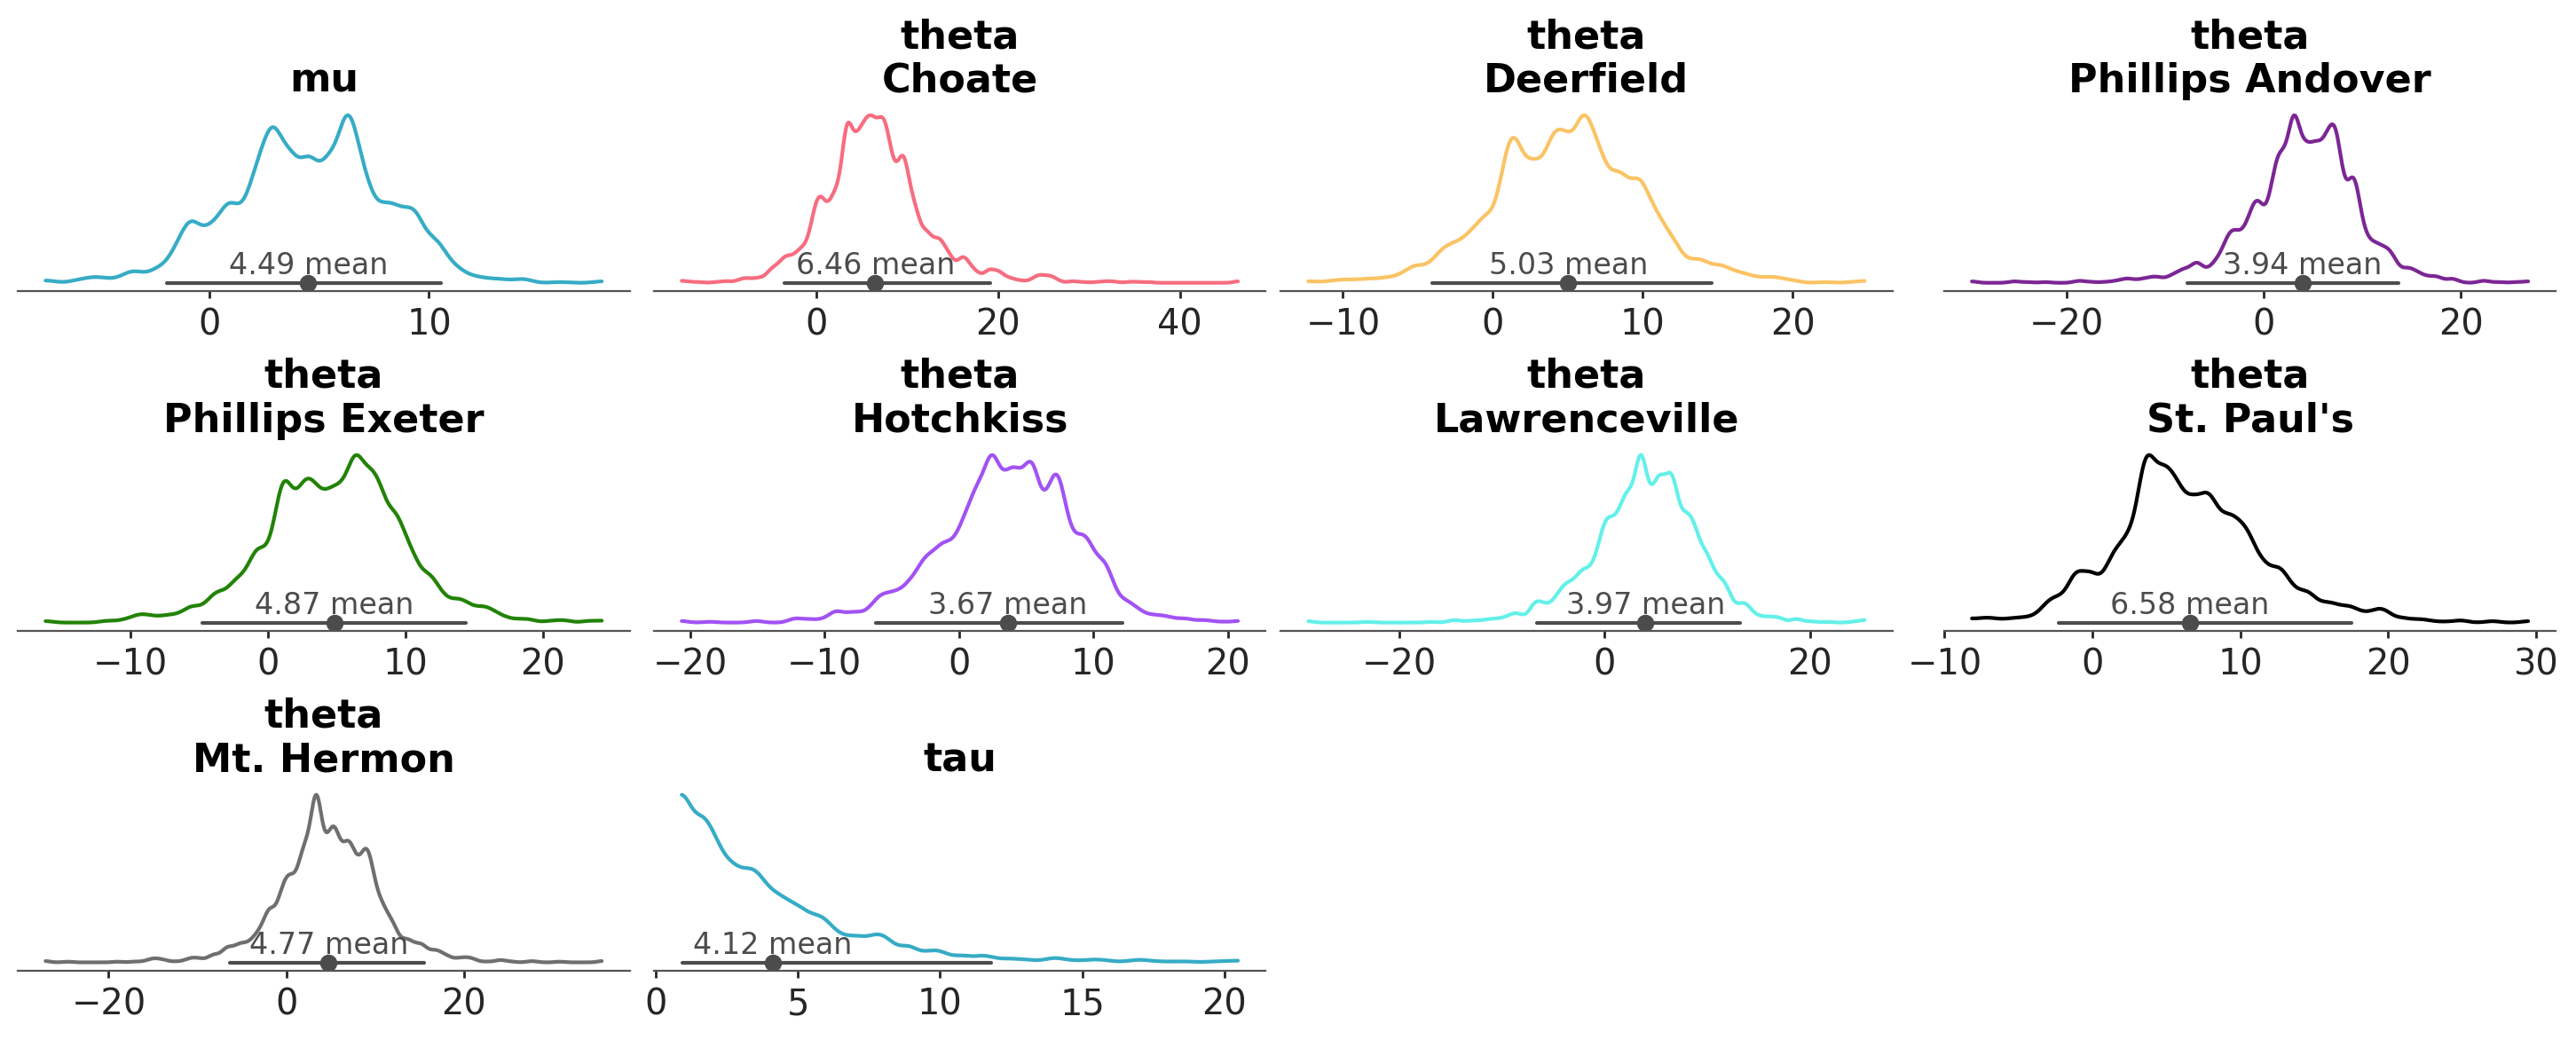

In [9]:
azp.plot_dist(
    schools,
    # encode the school information in the color property
    aes={"color": ["school"]},
);

Note that `mu` and `tau` have a common color, which is different to any of the `theta` lines. As they don't have the `school` dimension, `PlotCollection` then takes
the first element in the aesthetic (in this case "C0", the first color of the matplotlib color cycle) as _neutral element_, then generates a mapping excluding that element.
The _neutral element_ is therefore reserved to be used when the mapping can't be applied _and only then_.

Common aesthetics like `color` or `linestyle` get default values automatically, if possible from the active theme too, but we might want control over that for a specific plot or use an aesthetic for which automatic values are not available. Thanks to the call signature `plot_dist(..., **pc_kwargs)`, to do so we can use the aesthetic key directly within our function call:

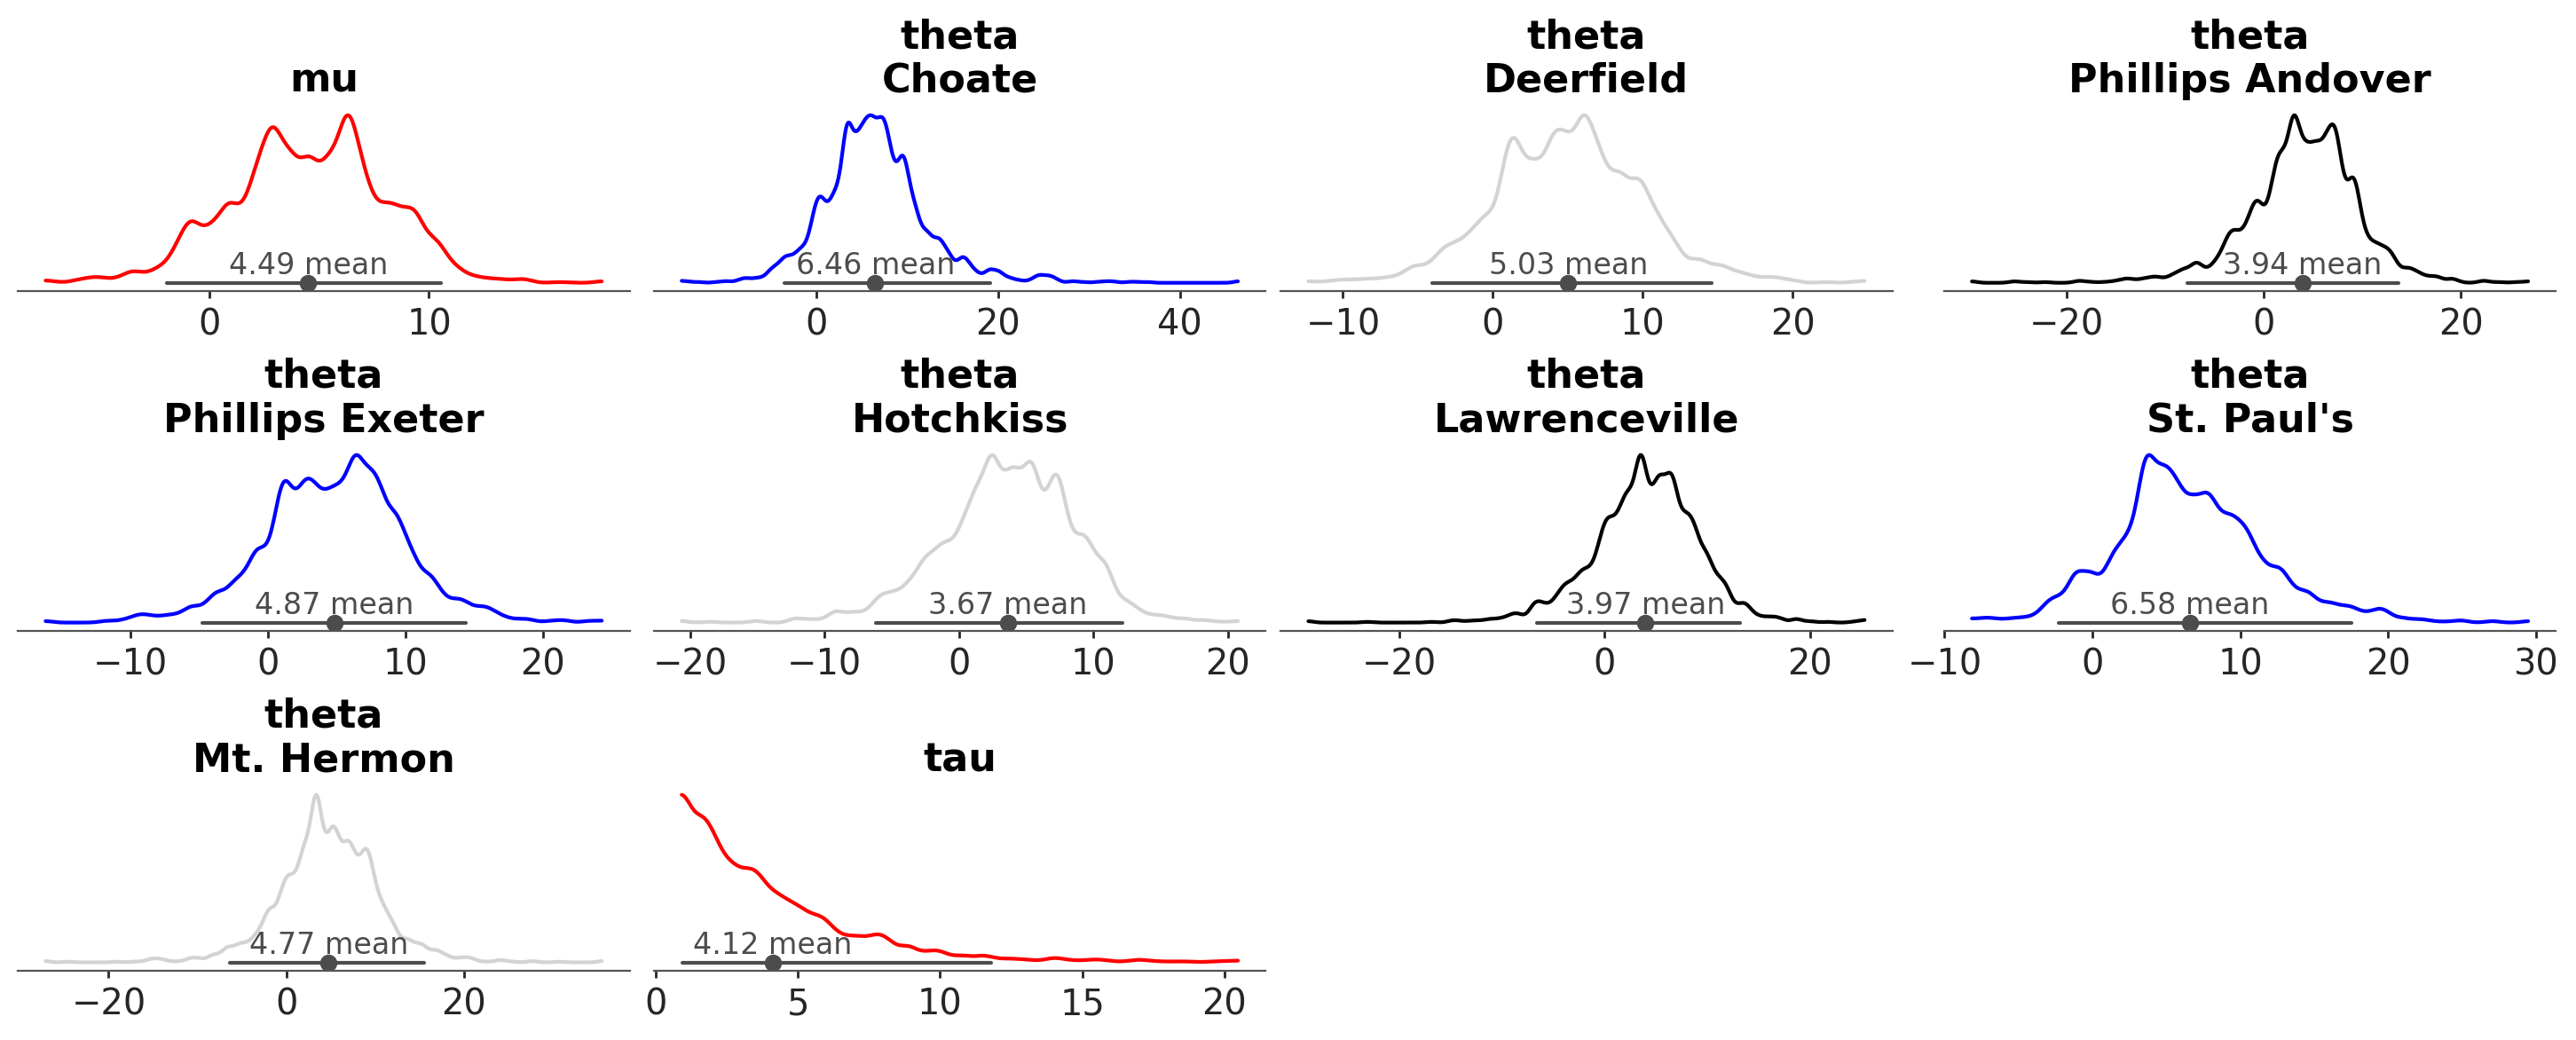

In [10]:
azp.plot_dist(
    schools,
    aes={"color": ["school"]},
    # manually set colors used
    color= ["red", "blue", "lightgray", "black"],
);

(plots_intro/disable_aes)=
### Removing aesthetic mappings from a visualization

Similarly, we can also use `pc_kwargs` to remove aesthetic mappings from plots that define them by default. For example, {func}`plot_trace_dist` by default maps the linestyle to the chain dimension and the color to the variable and all non sample dims together.

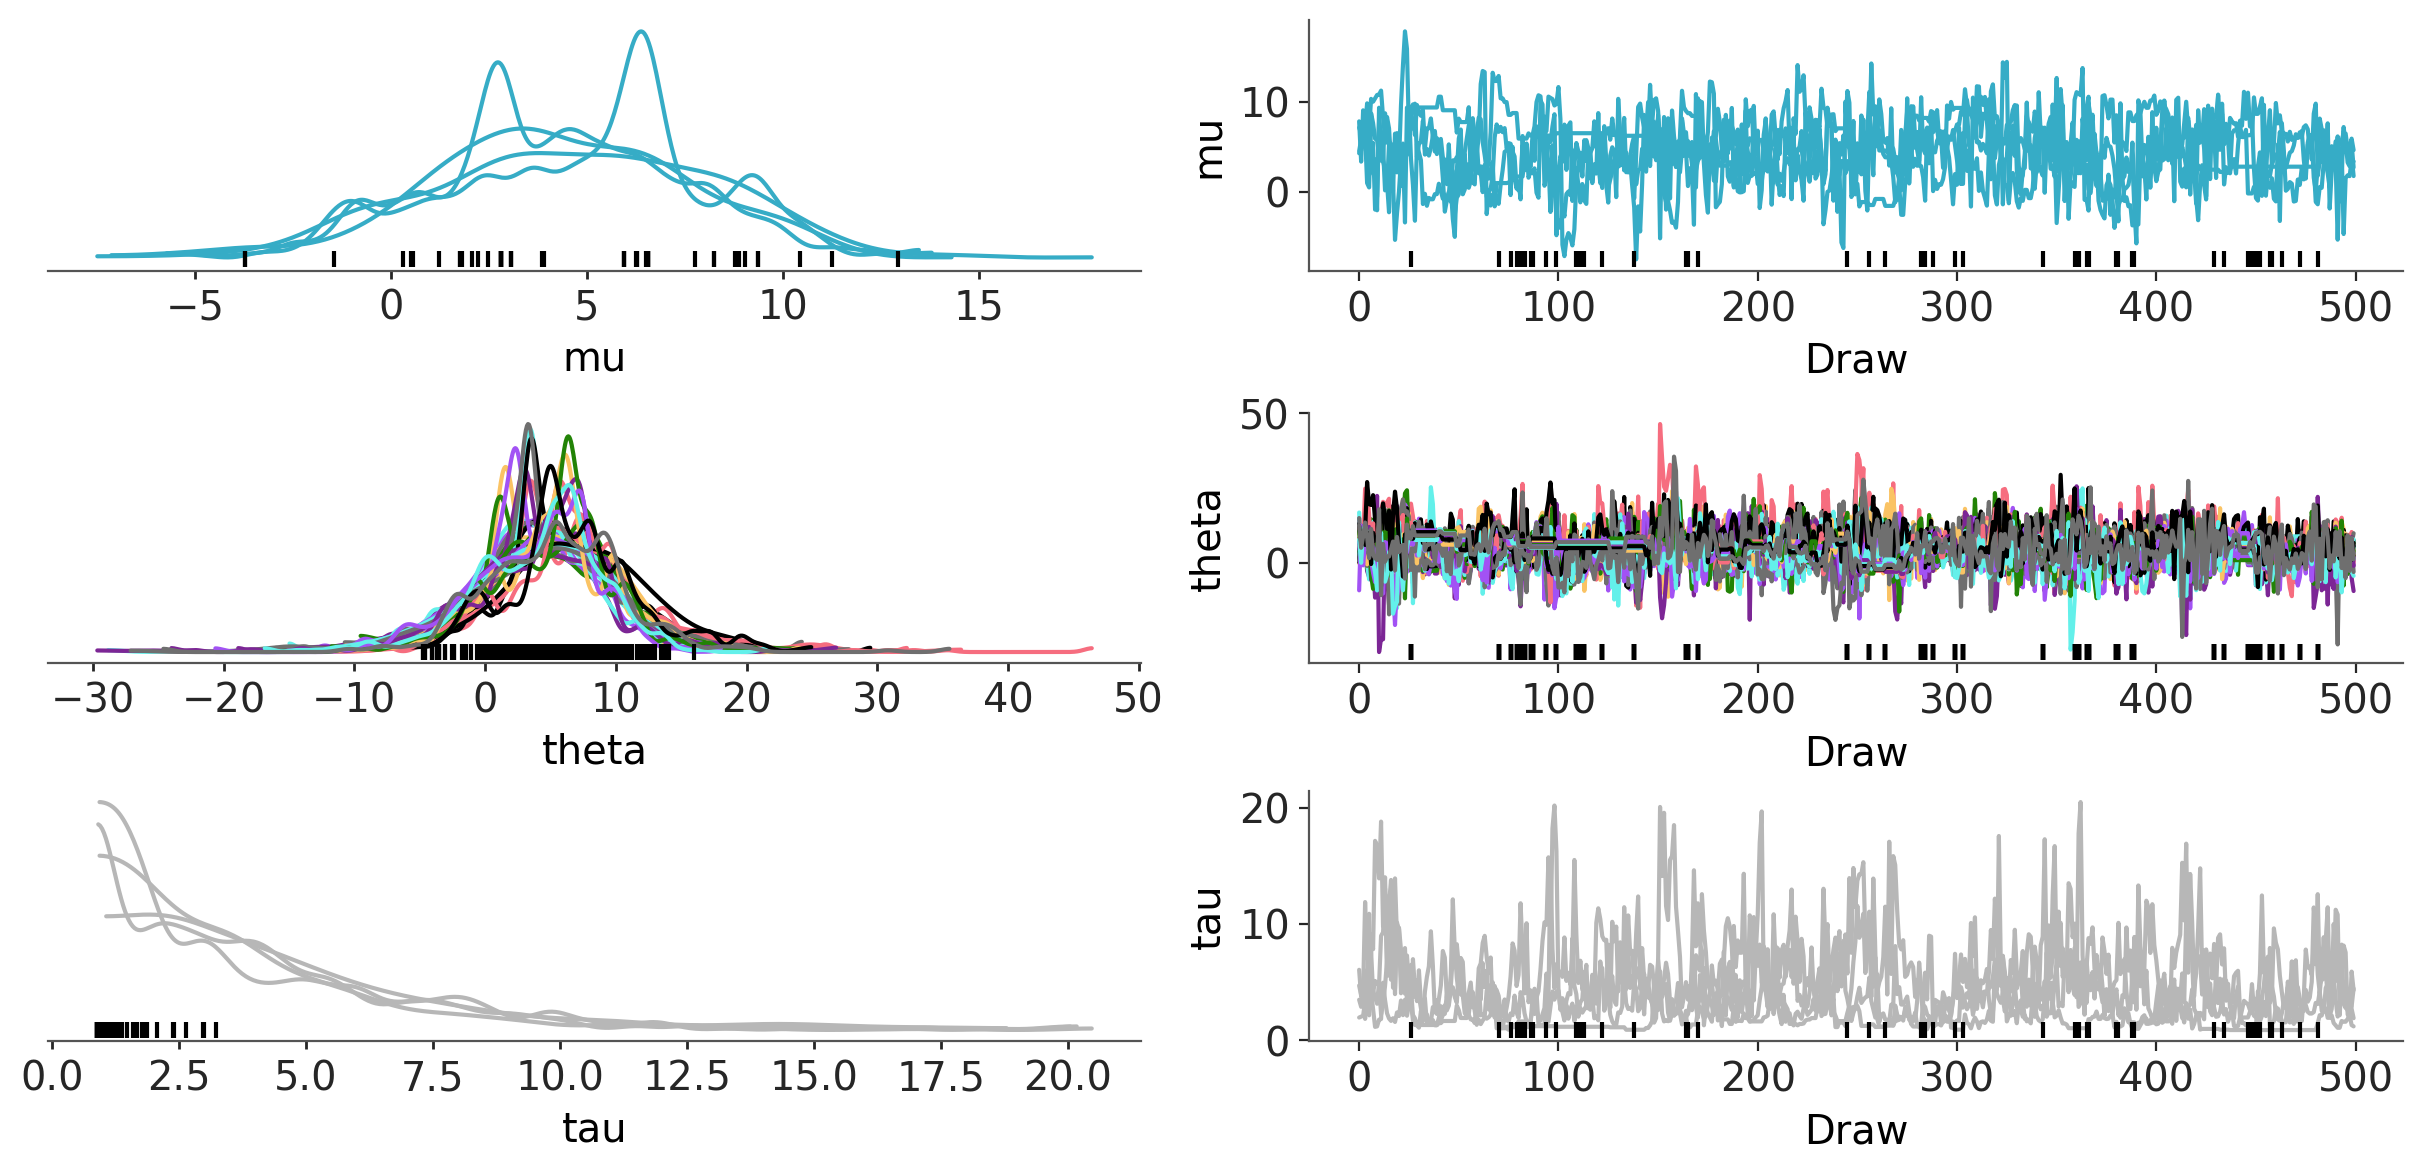

In [11]:
azp.plot_trace_dist(
    schools,
    aes={"linestyle": False},
);

### Choosing the visuals where aesthetic mappings are applied

We can configure which visuals take the defined aesthetic mappings into account with `aes_by_visuals`:

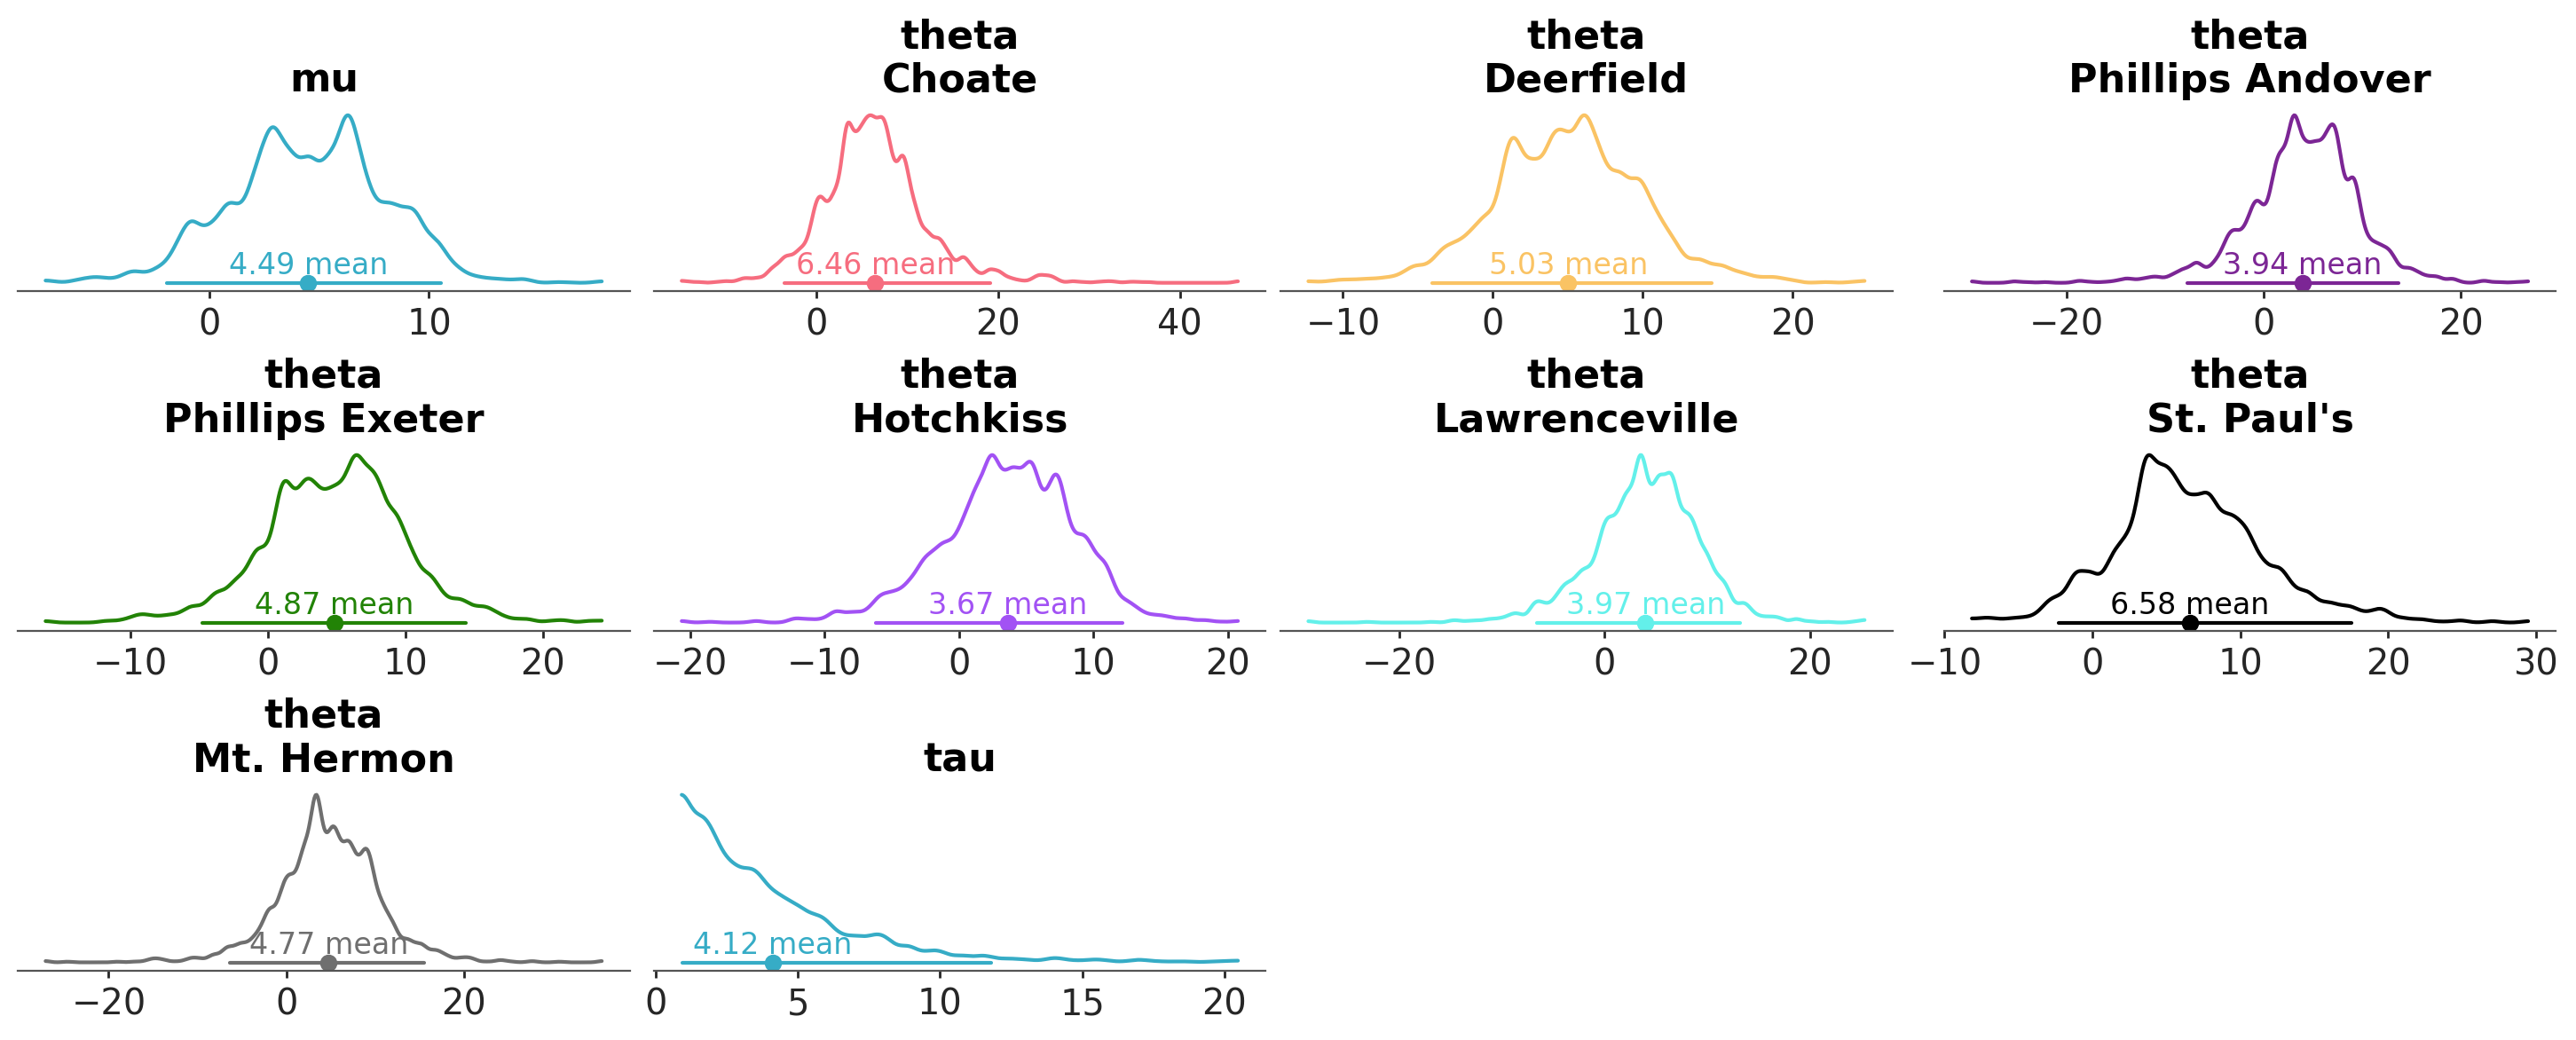

In [12]:
azp.plot_dist(
    schools,
    aes={"color": ["school"]},
    # apply the color-school mapping to all graphical elements but the title
    aes_by_visuals={
        "kde": ["color"],
        "point_estimate": ["color"],
        "credible_interval": ["color"]
    }
);

We can have as many aesthetic mappings as desired, and map all of them, none or a subset of them to the different graphical elements:

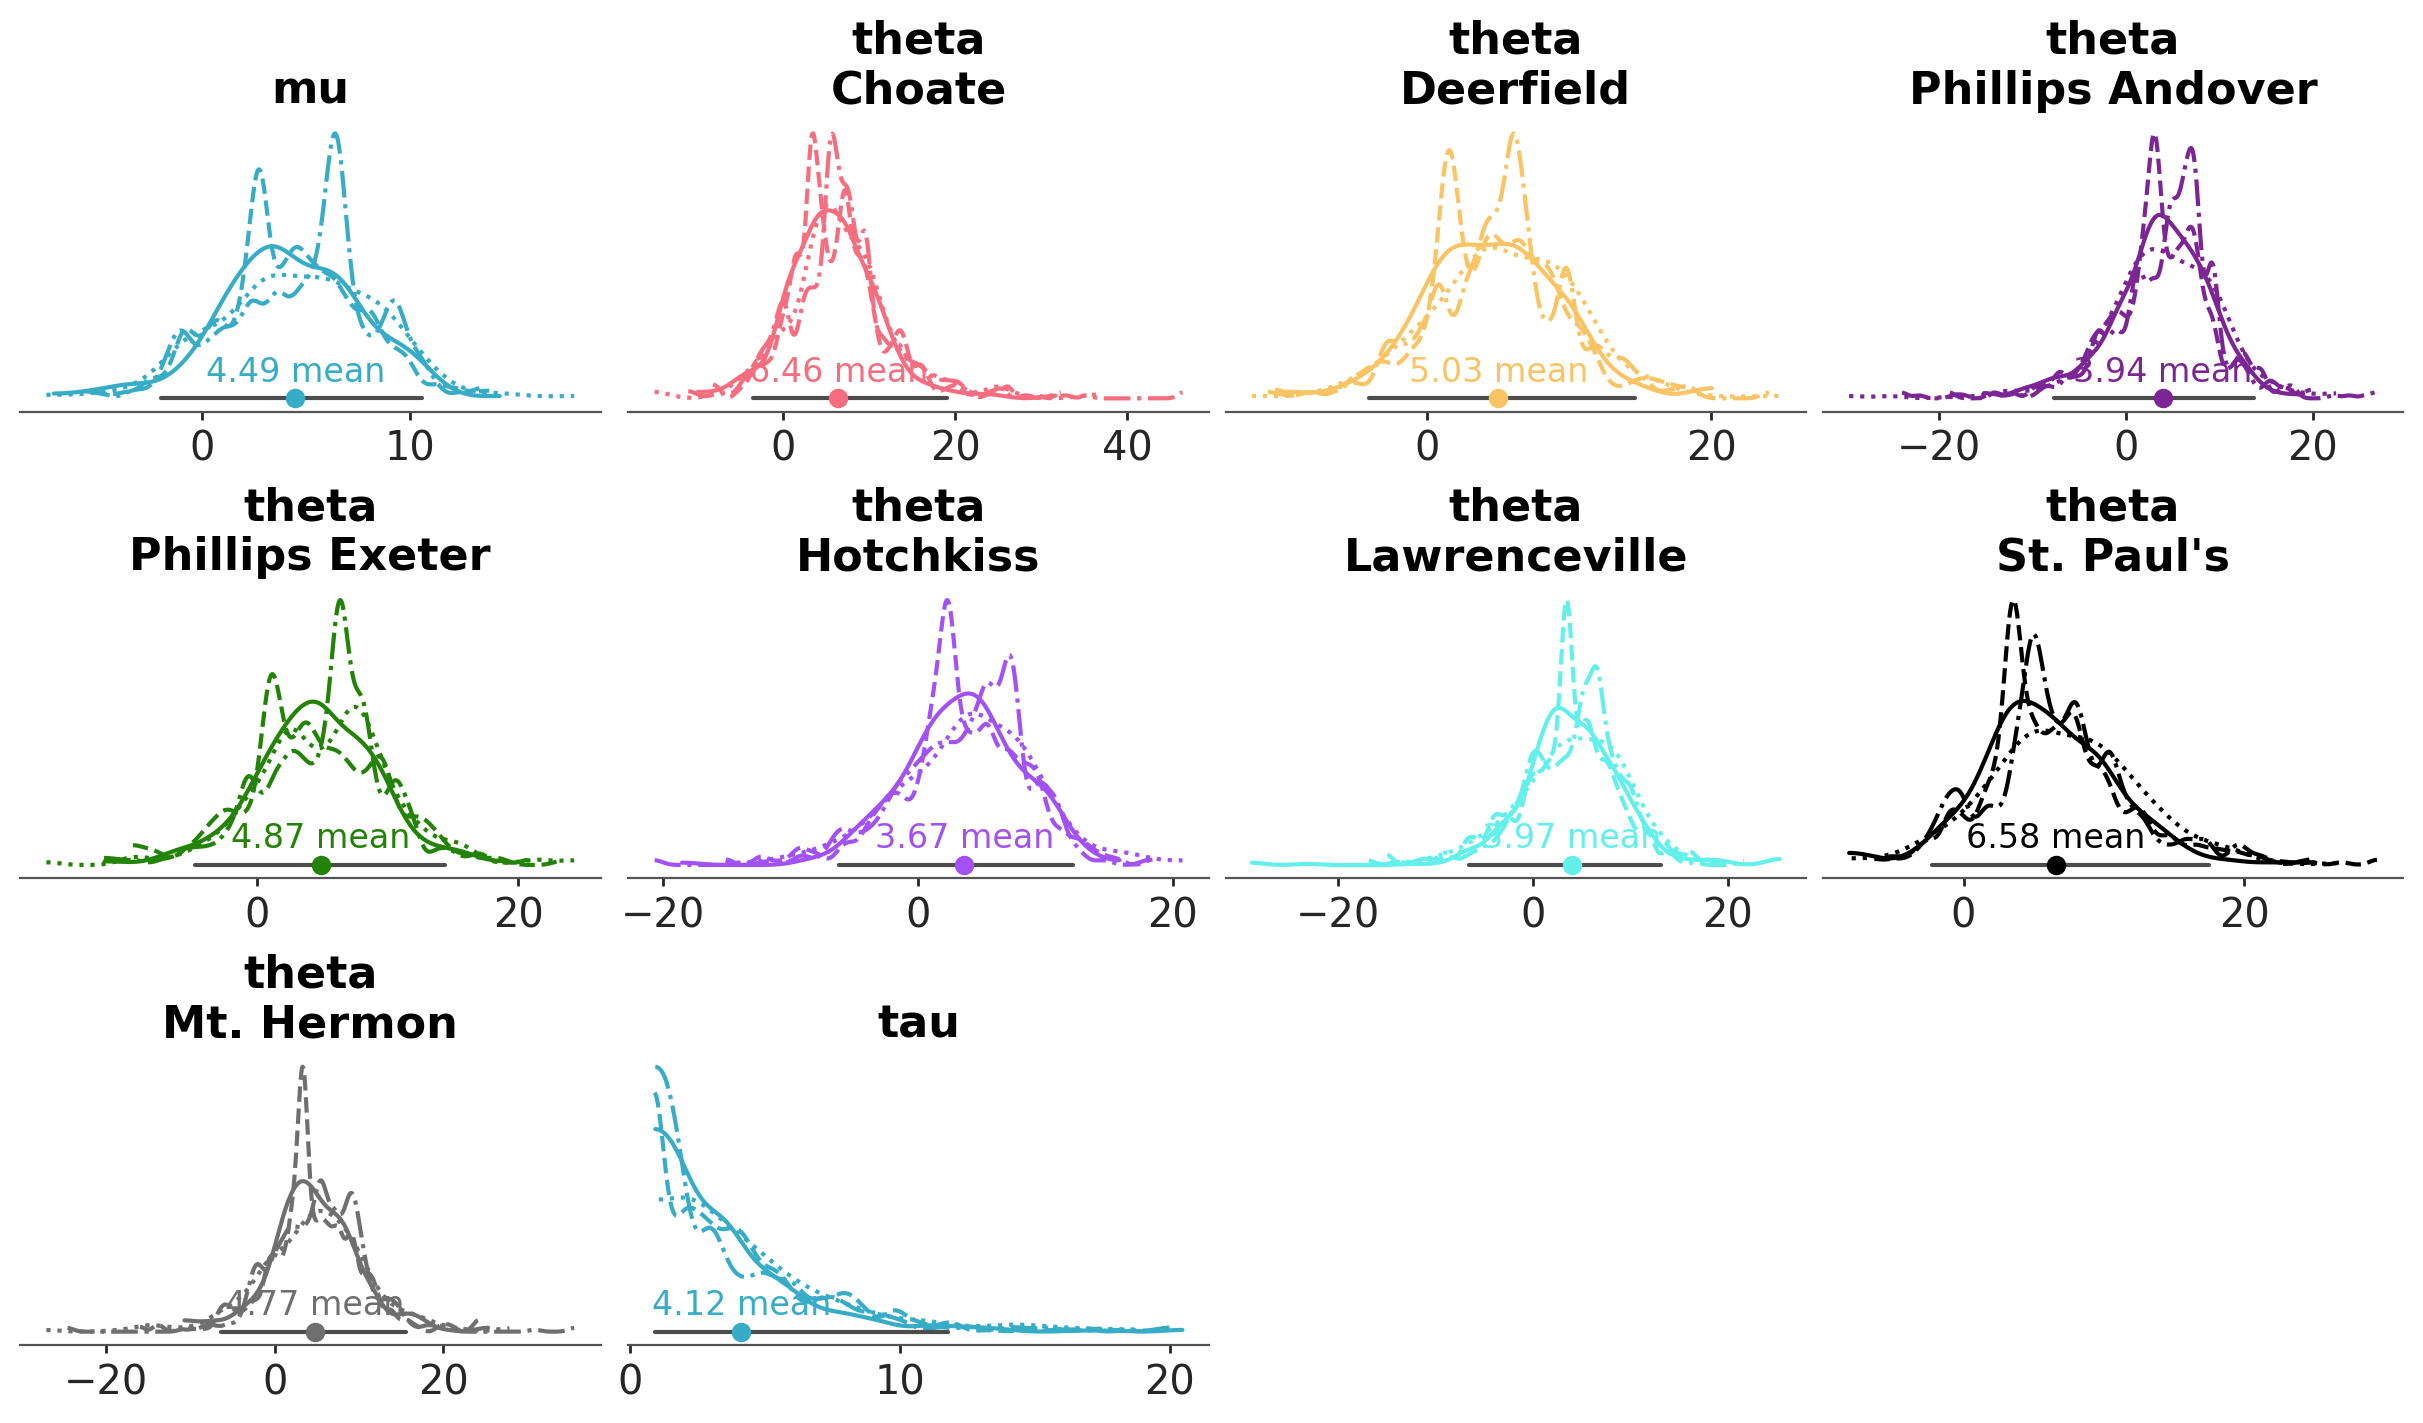

In [13]:
azp.plot_dist(
    schools, 
    aes={"color": ["school"], "linestyle": ["chain"]},
    figure_kwargs={"figsize": (12, 7)},
    aes_by_visuals={
        "kde": ["color", "linestyle"], # This is not necessary, as this mapping is the default
        "point_estimate": ["color"], # We extend the color-school mapping to the point estimate
    },
);

Note that now there is an aesthetic (linestyle) mapped to the `chain` dimension. Therefore, `PlotCollection` now loops over the `chain` dimension in order to enforce the aesthetic mapping, generating 4 KDE lines in each plot.

## Summary of the dictionary arguments

* `visuals`: Its keys should be graphical elements and its values should be dictionaries that are passed as is to the plotting functions. For example, if you want to change the color of the KDE, you can pass `visuals={'kde': {'color': 'red'}}`. Some other graphical elements for `plot_dist` are `point_estimate` or `title`. For each plot you will find the graphical elements that can be modified in the documentation.
* `stats`: Its keys should be a statistical element and its values should be dictionaries that are passed to the statistical functions. For example to change the bandwidth method used to represent the densities, via a KDE, we can use `stats={"density": {"bw": "scott"}}`. The other statistical elements for `plot_dist` are `credible_interval` and `point_estimate`. For each plot you will find the statistical elements that can be modified in the documentation.
* `**pc_kwargs`: These are passed to {meth}`~arviz_plots.PlotCollection.wrap`/{meth}`~arviz_plots.PlotCollection.grid` to initialize the `PlotCollection` object that takes care of faceting and aesthetics mapping, and to generate and manage the figure. For instance, to map the dataset property `school` to the graphical property `color` we use `aes={"color": ["school"]}`. To manually set the figure size we use `figure_kwargs={"figsize": (12, 7)}`.
* `aes_by_visuals`: Regulates which mappings apply to which graphical elements; by default, mappings only apply to the density representation. Thus if we have declared `aes= {"color": ["school"]` this will only apply to `kde`, if we want to extend the mapping to the title we will need to pass `aes_by_visuals={"title": ["color"]}`. The valid keys for `aes_by_visuals` are the same as the ones for `visuals`, i.e. are graphical elements.

## Legends

Legends are not automatic, but can be generated by the `PlotCollection` class which is returned by all `plot_...` functions:

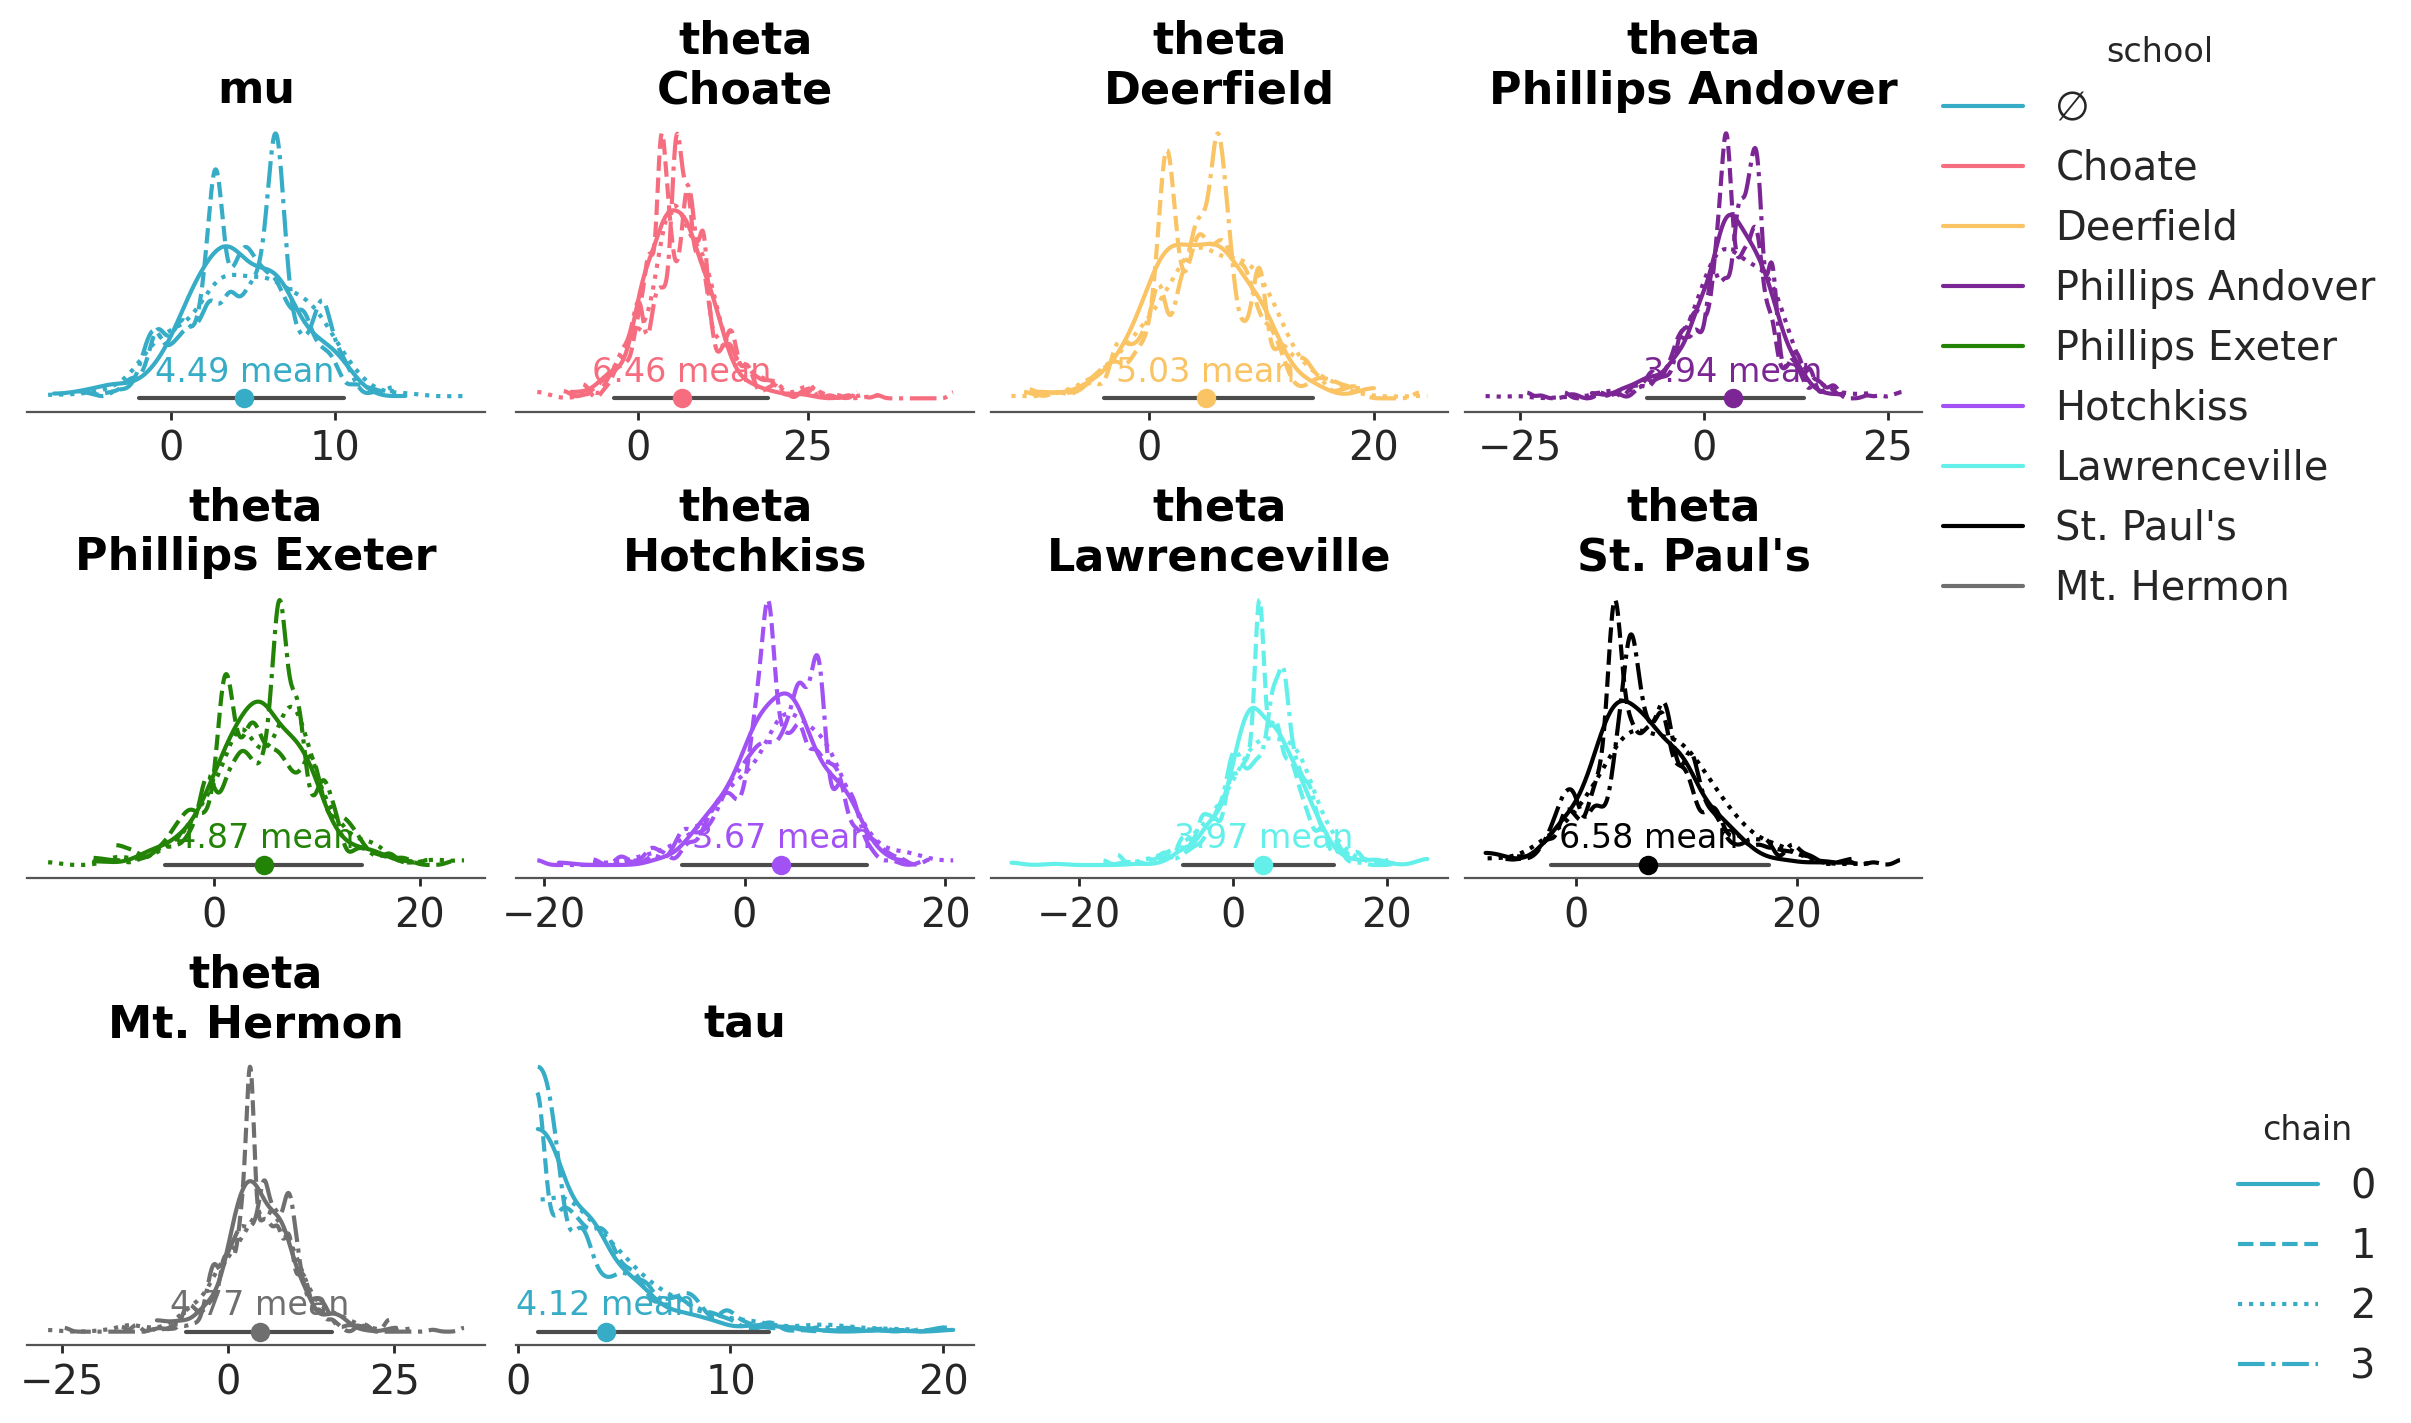

In [14]:
pc = azp.plot_dist(
    schools, 
    aes={"color": ["school"], "linestyle": ["chain"]},
    figure_kwargs= {"figsize": (12, 7)},
    aes_by_visuals={"kde": ["color", "linestyle"], "point_estimate": ["color"]},
)
pc.add_legend("school", loc="outside right upper")
pc.add_legend("chain", loc="outside right lower");

We mentioned the _neutral element_ when we defined the school->color mapping. `PlotCollection` only reserves the first element of the property cycle as _neutral element_ when necessary. In such cases it will be used when the mapping makes no sense as we have seen, and it will get "∅" as the label when generating a legend for that aesthetic mapping. You can see the _neutral element_ in the legend for the school mapping. On the other hand, the chain->linestyle mapping needs no neutral element, which is also shown in the legend.

(plots_intro/advanced)=
## Advanced examples
So far, we have looked at examples where the aesthetics with dataset properties mapped to them were only color and linestyle. Next, we will see how to use these arguments to do much more complex adjustments and discuss a bit what are the limitations on `PlotCollection` defined {term}`aesthetic mappings`.

When adjusting the aesthetics of a graphical element, the only limitation is that the keys and values are valid for the specific backend function being used. As long as this is satisfied, anything goes!

`PlotCollection` only manages the mapping. It defines and stores the {term}`aesthetic mappings` being used and then retrieves the requested subset and returns it as a key-value pair that gets passed to the plotting function. Neither keys or values are modified anywhere in the process.

The functions used by `plot_dist` (and by other `plot_...` functions) aim to be somewhat general. For example, `y` is a valid key for encoding information. But keep in mind that
if you want to generate plots significantly different from the default layout of `plot_dist` you'll need to follow the steps in {ref}`compose_own_plot` and use `PlotCollection` manually.

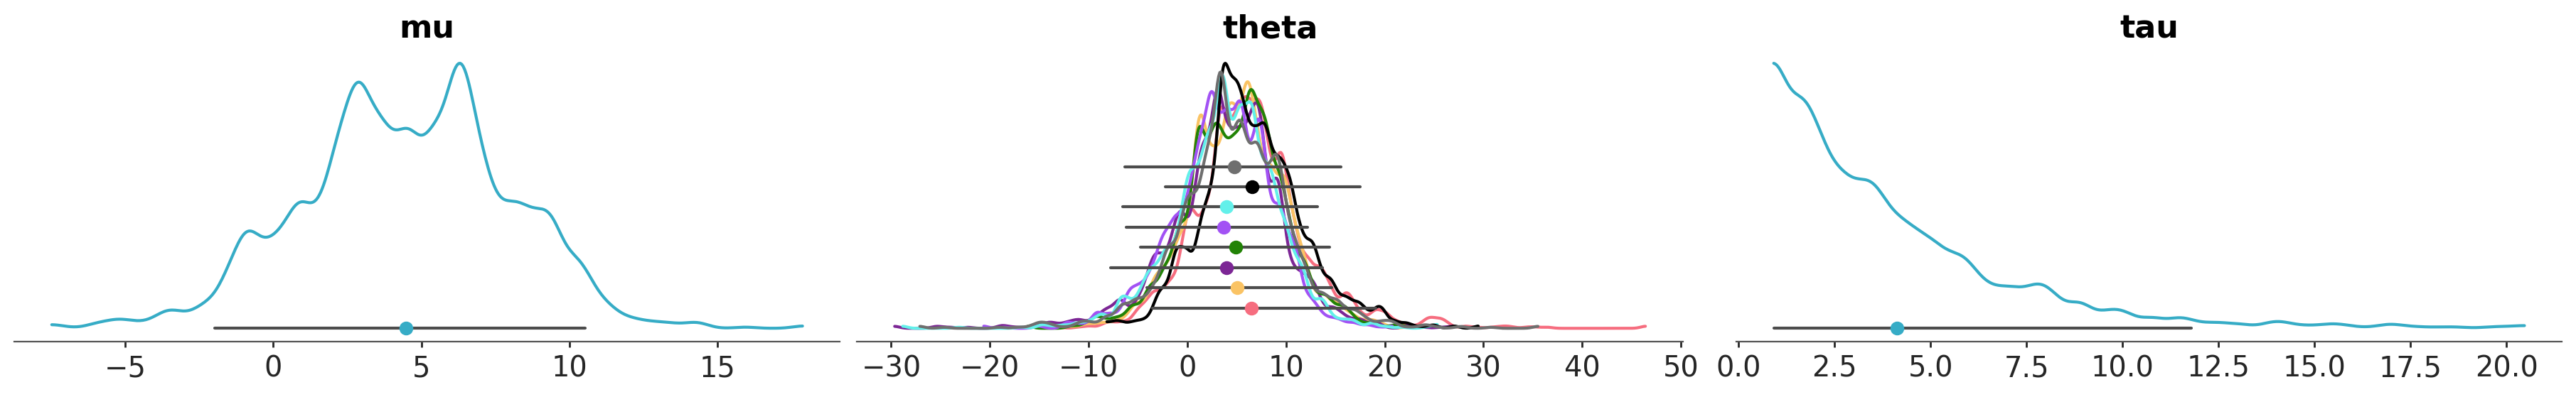

In [15]:
import numpy as np
azp.plot_dist(
    schools, 
    # stop creating one subplot per variable *and* coordinate value,
    # generate only one per variable, in this case 3 subplots
    cols= ["__variable__"],
    # encode the school information in both color and y properties
    aes= {"color": ["school"], "y": ["school"]},
    y= np.linspace(0, 0.06, 9),
    aes_by_visuals={
        "kde": ["color"],
        "point_estimate": ["color", "y"],
        "credible_interval": ["y"]
    },
    visuals={"point_estimate_text": False},
);

It is also possible to use the flexibility in what aesthetics can be combined with the interactive features of the plotly to use `legendgroup` as an "aesthetic" with mappings defined. This makes it possible to generate interactive legends <TODO: add plotly advanced examples and link>.

As we have seen, `PlotCollection` supports defining mappings using dimensions that aren't present in all the variables of the input data. It maintains the consistency fo the generated plots through the _neutral element_ we introduced. Moreover, `PlotCollection` also supports defining mappings using `__variable__`. `__variable__` acts as a pseudo-dimension when defining aesthetic mappings that indicates the value of that aesthetic should depend on the variable instead of any of its dimensions. Let's see it in action through an example.

When working with hierarchical models, it is common to want to compare how the distribution of each unit (each school, in the example we've been working with) compares to the population distribution implied by their shared hyperparameters. In general, these hyperparameters will be scalars, while the unit effects will have a dimension (e.g. school). Combining aesthetics applied to variables and to dimensions we can achieve just that and also illustrate the use of the `__variable__` pseudo-dimension.

In addition, we will use the special aesthetic "overlay". Any aesthetic starting with "overlay" will be taken into account when defining which subsets to loop over, but will be automatically removed by `PlotCollection` before sending the aesthetic key-value pairs to the plotting functions. This allows plotting multiple overlaid visual elements all with the same properties.

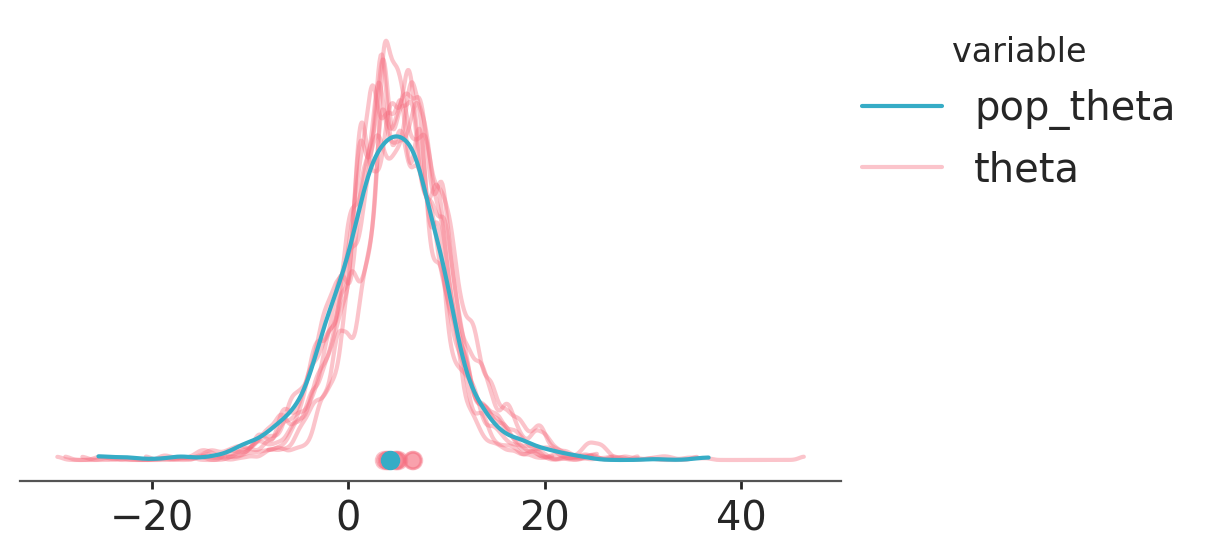

In [16]:
from xarray_einstats.stats import XrContinuousRV
from scipy.stats import norm

# compute population level theta
ds = schools.posterior.to_dataset()
ds["pop_theta"] = XrContinuousRV(norm, ds["mu"], ds["tau"]).rvs()
# overlay theta and computed pop_theta
pc = azp.plot_dist(
    ds,
    var_names=["pop_theta", "theta"],
    visuals={
        "credible_interval": False,
        "point_estimate_text": False,
        "title": False,
    },
    cols= [],
    aes= {
        "color": ["__variable__"],
        "alpha": ["__variable__"],
        "zorder": ["__variable__"],
        "overlay": ["school"],
    },
    # manually set the values for alpha and zorder
    # alpha has default values but they don't fit our current case
    # zorder doesn't have default values
    alpha=[1, 0.4],
    zorder=[3, 2],
    aes_by_visuals={"point_estimate": ["color", "overlay", "alpha", "zorder"]},
)
pc.add_legend("__variable__");

Note that we have defined an aesthetic mapping on `zorder`. This works because we are using matplotlib as our backend, but wouldn't work in either bokeh or plotly. In fact,
bokeh has no equivalent to matplotlib's zorder. In general, the best way to control the order in which graphical elements are overlaid is controlling the order in which they are plotted. Visuals plotted first will end up at the bottom and visuals plotted last at the top. Consequently, using `var_names=["theta", "pop_theta"]` and removing all uses of `zorder` would achive basically the same plot and work in all backends.

We can have a range of variables with different shapes and dimensions. As long as we are careful that the facetting and mapping arguments do not conflict,
the underlying `PlotCollection` used by `plot_dist` can combine all the different variables into a single figure. The provided aesthetic mappings only be taken into account when relevant:

Here for example we have 4 variables: one is two dimensional, two have 3 dimensions (but different dimensions for their 3rd one) and one has 4 dimensions:

In [17]:
rugby = load_arviz_data("rugby_field")
rugby.posterior.ds[["atts_team", "atts", "intercept", "sd_att"]]

<xarray.Dataset> Size: 340kB
Dimensions:    (chain: 4, draw: 500, team: 6, field: 2)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * field      (field) <U4 32B 'home' 'away'
  * team       (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
Data variables:
    atts_team  (chain, draw, team) float64 96kB -0.1502 -0.2281 ... 0.8107
    atts       (chain, draw, field, team) float64 192kB 0.6336 ... 0.09205
    intercept  (chain, draw, field) float64 32kB 3.147 2.998 ... 3.225 2.956
    sd_att     (chain, draw) float64 16kB 3.797 0.3617 0.4588 ... 1.203 1.875
Attributes:
    created_at:                 2024-02-23T20:21:03.016373
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4+7.g34d2a5d9
    sampling_time:              21.146891355514526
    tuning_steps:               1000

We will encode 3 different dataset properties in our figure:

* Each combination of variable and team coordinate value (if present) will have their own {term}`plot`. We achieve defining the faceting as `cols=["__variable__", "team"]`.
* The field information (a dimension present in 2 out of our 4 variables) will have mappings to the linestyle, marker, and y aesthetics.
* The team information (a dimension present in 2 out of our 4 variables) will be encoded in the color of the visual elements.

We define all {term}`aesthetic mappings` through the `aes` keyword argument. Then, we specify which mappings should each visual use through `aes_by_visual`.

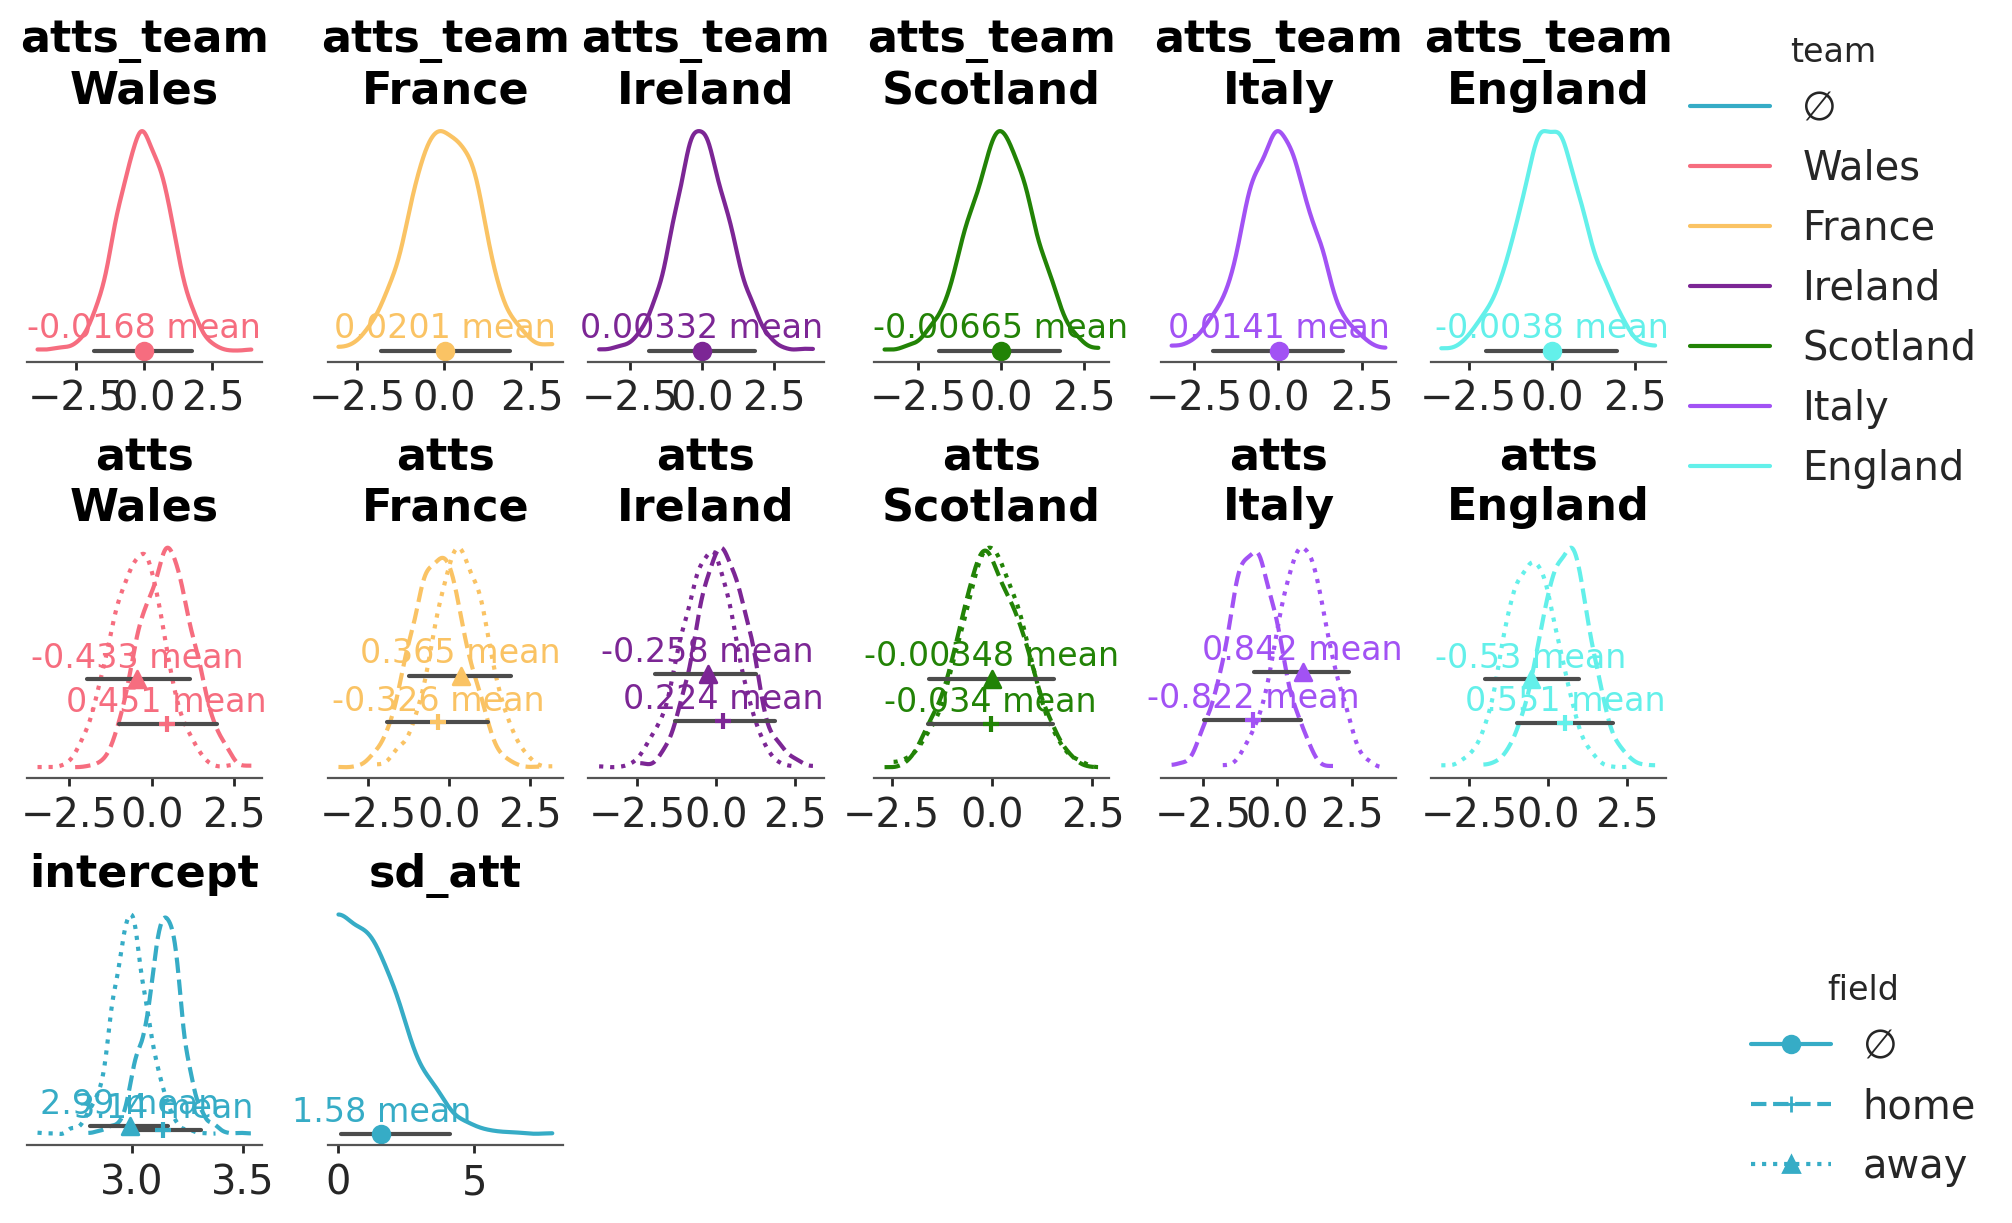

In [18]:
pc = azp.plot_dist(
    rugby,
    var_names=["atts_team", "atts", "intercept", "sd_att"],
    cols=["__variable__", "team"],
    col_wrap=6,
    figure_kwargs={"figsize": (10, 6)},
    aes= {
        "linestyle": ["field"],
        "color": ["team"],
        "marker": ["field"],
        "y": ["field"]
    },
    y=[0, 0.1, 0.2],
    aes_by_visuals={
        "kde": ["color", "linestyle"],
        "point_estimate": ["color", "marker", "y"],
        "point_estimate_text": ["color", "y"],
        "credible_interval": ["y"]
    },
)
pc.add_legend("team")
pc.add_legend("field", loc="outside right lower");

:::{seealso}
* {ref}`use_plotcollection` covers handling of `PlotCollection` objects to further customize and inspect the plots generated with batteries-included functions.
* {ref}`compose_own_plot` shows how to create and fill visualizations from scratch using `PlotCollection` to allow you to generate your own specific plotting functions,
  or to generate domain specific batteries-included ones
:::